Машины опорных векторов (сокращенно SVM) — это контролируемые алгоритмы машинного обучения, которые используются для целей классификации и регрессии. В этом задании вам необходимо обучить Support Vector Machines для классификации пульсаров. 


**1. Прочитайте данные, сделайте беглый EDA - посмотрите на кол-во данных, названия столбцов, нет ли в них ошибок, переименуйте для более удобной работы, есть ли пропущенные значения. Посмотрите нет ли дисбаланса классов по таргету? Сделайте саммари по признакам. Отобразите боксплоты признаков, чтобы оценить выбросы в данных. Постройте гистограммы признаков, чтобы взглянуть на распределение данных.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
%matplotlib inline

In [2]:
#TODO
df = pd.read_csv('pulsar_data_train.csv')
df.head(5)

,Mean of the integrated profile,Standard deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve,target_class
0,121.156250,48.372971,0.375485,-0.013165,3.168896,18.399367,7.449874,65.159298,0.0
1,76.968750,36.175557,0.712898,3.388719,2.399666,17.570997,9.414652,102.722975,0.0
2,130.585938,53.229534,0.133408,-0.297242,2.743311,22.362553,8.508364,74.031324,0.0
3,156.398438,48.865942,-0.215989,-0.171294,17.471572,NaN,2.958066,7.197842,0.0
4,84.804688,36.117659,0.825013,3.274125,2.790134,20.618009,8.405008,76.291128,0.0


In [3]:
df.columns = ['Mean of the integrated profile','Standard deviation of the integrated profile',
              'Excess kurtosis of the integrated profile','Skewness of the integrated profile',
              'Mean of the DM-SNR curve','Standard deviation of the DM-SNR curve',
             'Excess kurtosis of the DM-SNR curve','Skewness of the DM-SNR curve','target_class']

In [4]:
df.columns

Index(['Mean of the integrated profile',
       'Standard deviation of the integrated profile',
       'Excess kurtosis of the integrated profile',
       'Skewness of the integrated profile', 'Mean of the DM-SNR curve',
       'Standard deviation of the DM-SNR curve',
       'Excess kurtosis of the DM-SNR curve', 'Skewness of the DM-SNR curve',
       'target_class'],
      dtype='object')

In [5]:
len(df)

12528

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12528 entries, 0 to 12527
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Mean of the integrated profile                12528 non-null  float64
 1   Standard deviation of the integrated profile  12528 non-null  float64
 2   Excess kurtosis of the integrated profile     10793 non-null  float64
 3   Skewness of the integrated profile            12528 non-null  float64
 4   Mean of the DM-SNR curve                      12528 non-null  float64
 5   Standard deviation of the DM-SNR curve        11350 non-null  float64
 6   Excess kurtosis of the DM-SNR curve           12528 non-null  float64
 7   Skewness of the DM-SNR curve                  11903 non-null  float64
 8   target_class                                  12528 non-null  float64
dtypes: float64(9)
memory usage: 881.0 KB


### Проверяем наличие нулей

In [7]:
df.isnull().sum()

Mean of the integrated profile                     0
Standard deviation of the integrated profile       0
Excess kurtosis of the integrated profile       1735
Skewness of the integrated profile                 0
Mean of the DM-SNR curve                           0
Standard deviation of the DM-SNR curve          1178
Excess kurtosis of the DM-SNR curve                0
Skewness of the DM-SNR curve                     625
target_class                                       0
dtype: int64

### Удаляем строчки где встречаются 3 пустых значения

In [8]:
df = df[~((df['Standard deviation of the DM-SNR curve'].isnull())&
          (df['Excess kurtosis of the integrated profile'].isnull())&
          (df['Skewness of the DM-SNR curve'].isnull()))]

Сморим сколько строчек находятся в каждом классе

In [9]:
df['target_class'].value_counts()

0.0    11372
1.0     1151
Name: target_class, dtype: int64

Смотрим выбросы boxplot без гораничений

<AxesSubplot:>

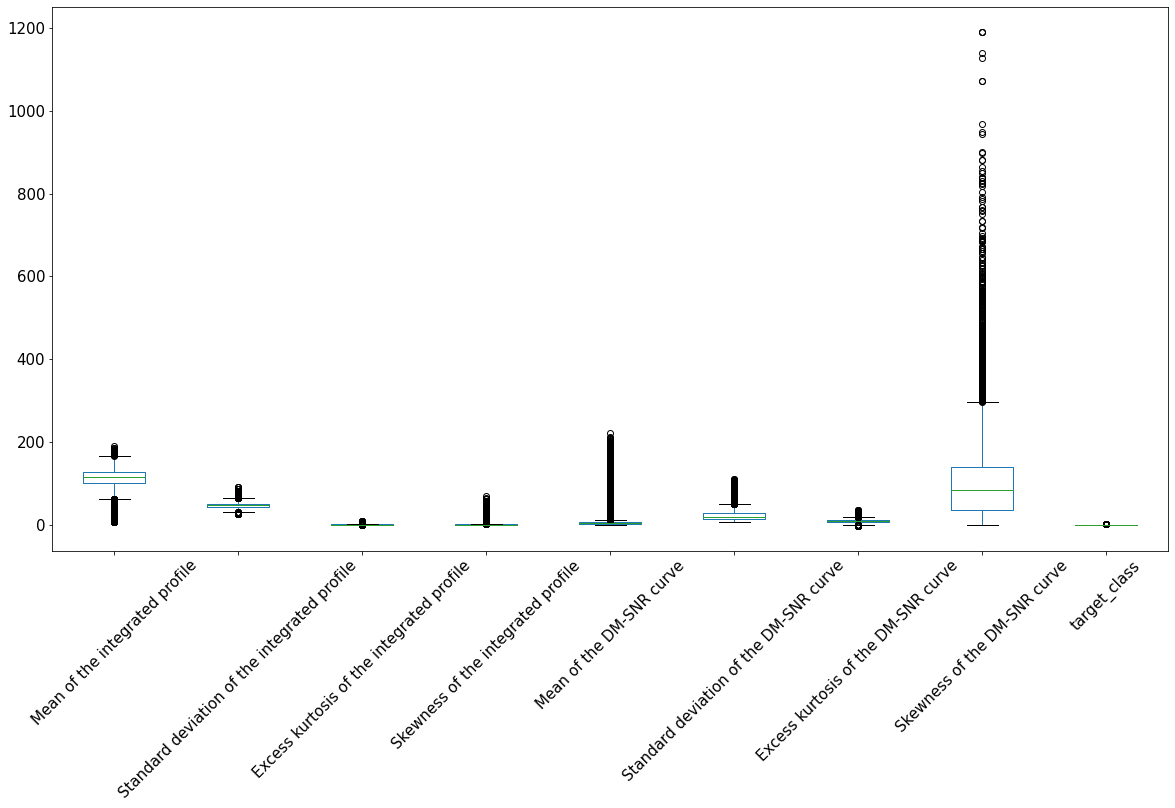

In [10]:
df.boxplot(grid=False,figsize=(20,10),rot=45,fontsize=15)

<AxesSubplot:>

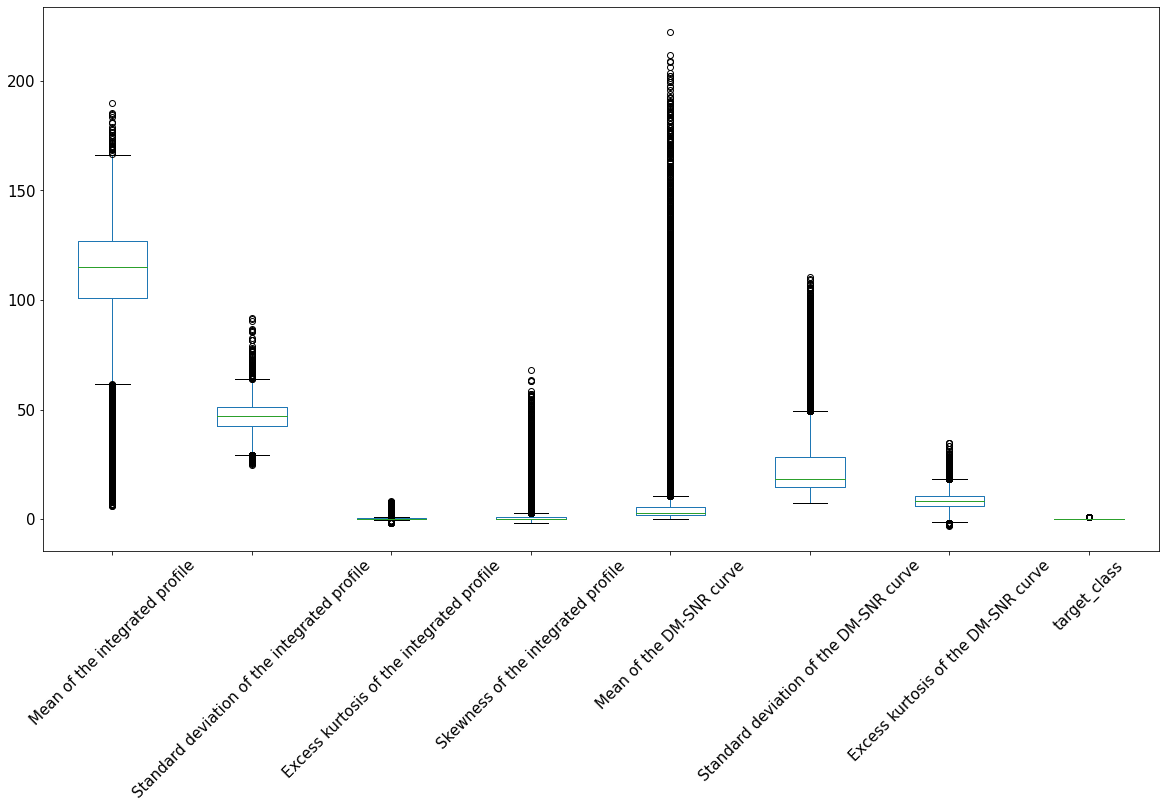

In [11]:
df.drop('Skewness of the DM-SNR curve', axis=1).boxplot(grid=False,
                                                        figsize=(20,10),
                                                        rot=45,
                                                        fontsize=15)

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Skewness of the DM-SNR curve'>

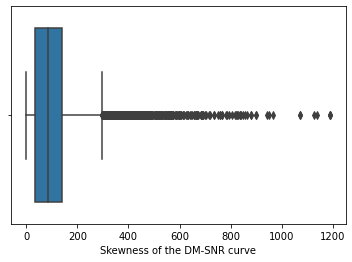

In [12]:
sns.boxplot(df['Skewness of the DM-SNR curve'])

Смотрим выбросы boxplot в строчках где 'Skewness of the DM-SNR curve' = null &
'target_class' = 0

<AxesSubplot:>

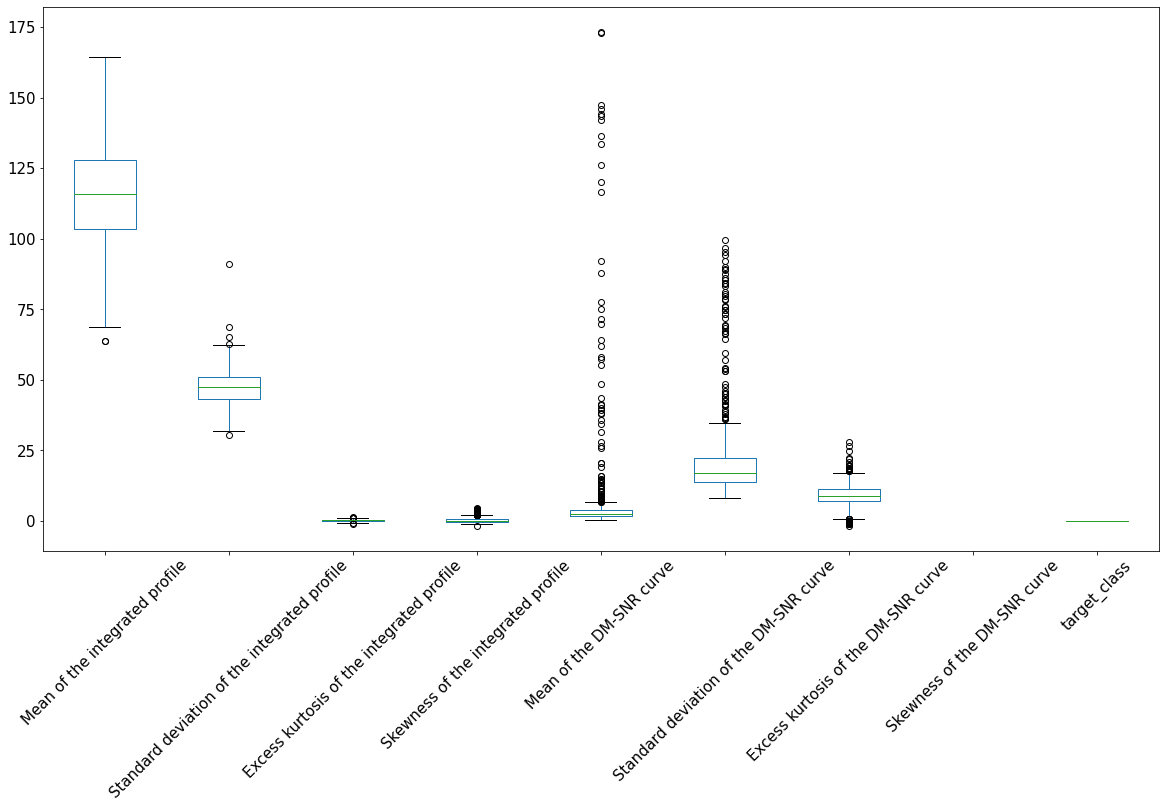

In [13]:
df[(df['Skewness of the DM-SNR curve'].isnull())&
   (df['target_class'] == 0)].boxplot(grid=False,figsize=(20,10),
                                      rot=45,fontsize=15)

Смотрим df по boxplot по столбцам и убераем выбрасы чтобы найти mean

Mean of the integrated profile

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Mean of the integrated profile'>

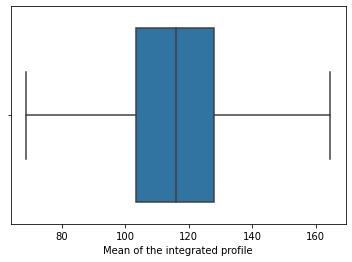

In [14]:
sns.boxplot(df[(df['Skewness of the DM-SNR curve'].isnull())&
               (df['target_class'] == 0)&
               (df['Mean of the integrated profile']>64)]
            ['Mean of the integrated profile'])

Standard deviation of the integrated profile

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Standard deviation of the integrated profile'>

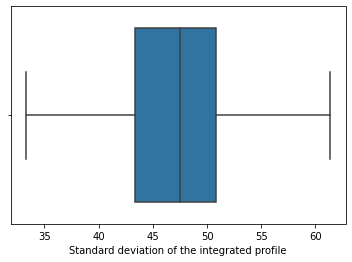

In [15]:
sns.boxplot(df[(df['Skewness of the DM-SNR curve'].isnull())&
               (df['target_class'] == 0)&
               (df['Standard deviation of the integrated profile']>32.5)&
               (df['Standard deviation of the integrated profile']<61.5)]
            ['Standard deviation of the integrated profile'])

Excess kurtosis of the integrated profilem

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Excess kurtosis of the integrated profile'>

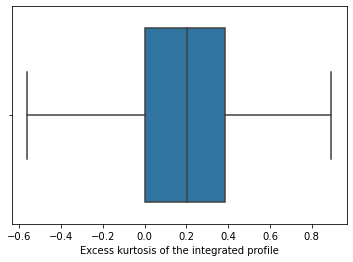

In [16]:
sns.boxplot(df[(df['Skewness of the DM-SNR curve'].isnull())&
               (df['target_class'] == 0)&
               (df['Excess kurtosis of the integrated profile']>-0.64)&
               (df['Excess kurtosis of the integrated profile']<0.97)]
            ['Excess kurtosis of the integrated profile'])

Skewness of the integrated profile

In [17]:
df[(df['Skewness of the DM-SNR curve'].isnull())&
               (df['target_class'] == 0)]\
['Skewness of the integrated profile'].quantile(0.875)

1.4365792536250002

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Skewness of the integrated profile'>

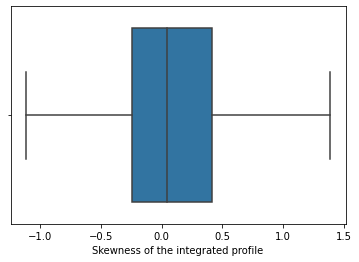

In [18]:
sns.boxplot(df[(df['Skewness of the DM-SNR curve'].isnull())&
               (df['target_class'] == 0)&
               (df['Skewness of the integrated profile']>-1.7)&
               (df['Skewness of the integrated profile']<1.436)]
            ['Skewness of the integrated profile'])

Mean of the DM-SNR curve

In [19]:
df[(df['Skewness of the DM-SNR curve'].isnull())&
               (df['target_class'] == 0)]\
['Mean of the DM-SNR curve'].quantile(0.8175)

4.866812290972502

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Mean of the DM-SNR curve'>

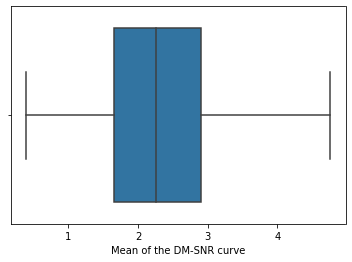

In [20]:
sns.boxplot(df[(df['Skewness of the DM-SNR curve'].isnull())&
               (df['target_class'] == 0)&
               (df['Mean of the DM-SNR curve']<4.86)]
            ['Mean of the DM-SNR curve'])

Standard deviation of the DM-SNR curve

In [21]:
df[(df['Skewness of the DM-SNR curve'].isnull())&
               (df['target_class'] == 0)]\
['Standard deviation of the DM-SNR curve'].quantile(0.828)

27.739610154639973

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Standard deviation of the DM-SNR curve'>

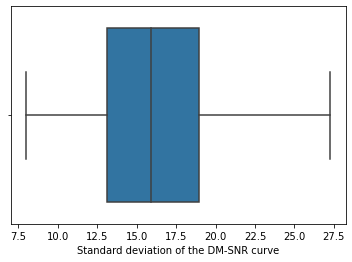

In [22]:
sns.boxplot(df[(df['Skewness of the DM-SNR curve'].isnull())&
               (df['target_class'] == 0)&
               (df['Standard deviation of the DM-SNR curve']<27.8)]
            ['Standard deviation of the DM-SNR curve'])

Excess kurtosis of the DM-SNR curve

In [23]:
df[(df['Skewness of the DM-SNR curve'].isnull())&
               (df['target_class'] == 0)]\
['Excess kurtosis of the DM-SNR curve'].quantile(0.057)

1.7654949845439998

In [24]:
df[(df['Skewness of the DM-SNR curve'].isnull())&
               (df['target_class'] == 0)]\
['Excess kurtosis of the DM-SNR curve'].quantile(0.958)

16.600339326659977

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Excess kurtosis of the DM-SNR curve'>

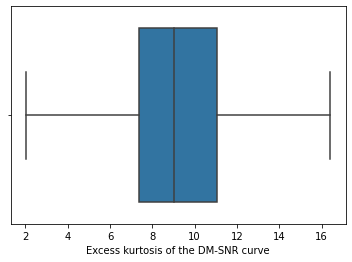

In [25]:
sns.boxplot(df[(df['Skewness of the DM-SNR curve'].isnull())&
               (df['target_class'] == 0)&
               (df['Excess kurtosis of the DM-SNR curve']>1.8)&
               (df['Excess kurtosis of the DM-SNR curve']<16.7)]
            ['Excess kurtosis of the DM-SNR curve'])

Вносми получиные значения в условия и смотрим выбросы и количество строчек

Количество строчек: 281


<AxesSubplot:>

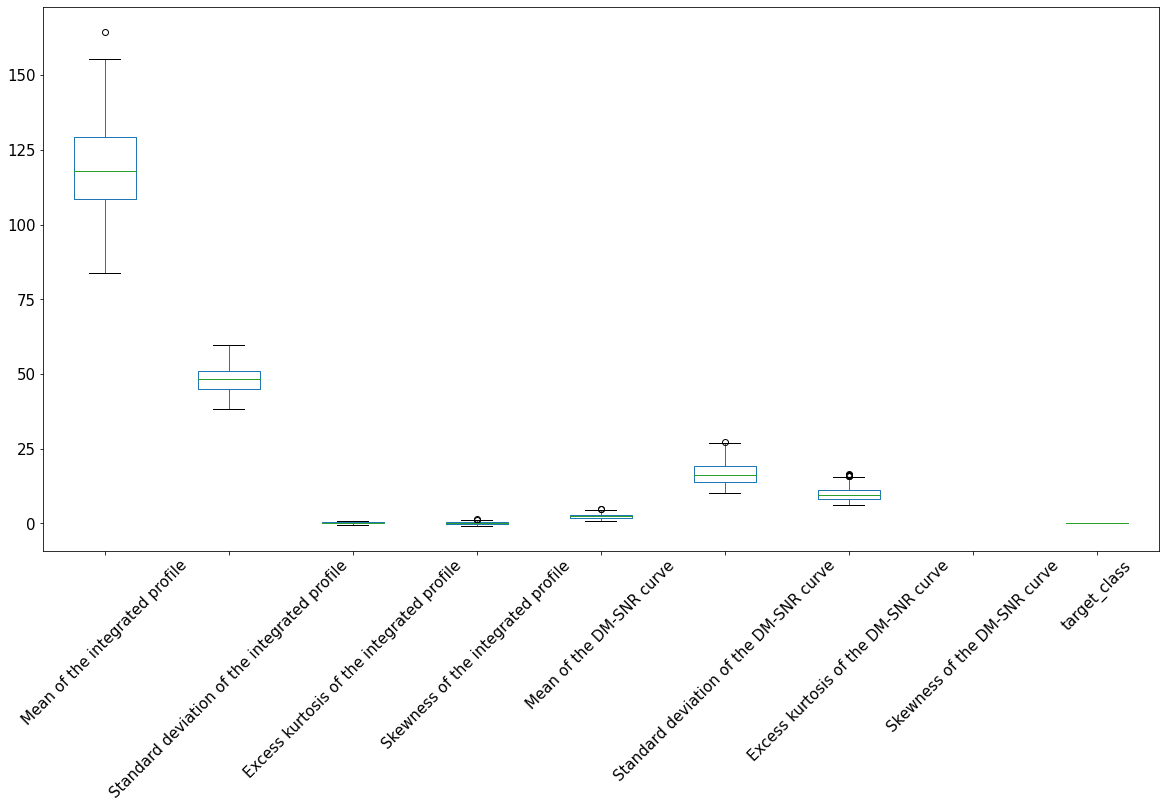

In [26]:
df_if = ((df['target_class'] == 0)&
         (df['Skewness of the DM-SNR curve'].isnull())&
         (df['Mean of the integrated profile']>64)&
         (df['Standard deviation of the integrated profile']>32.5)&
         (df['Standard deviation of the integrated profile']<61.5)&
         (df['Excess kurtosis of the integrated profile']>-0.64)&
         (df['Excess kurtosis of the integrated profile']<0.97)&
         (df['Skewness of the integrated profile']>-1.7)&
         (df['Skewness of the integrated profile']<1.436)&
         (df['Mean of the DM-SNR curve']<4.86)&
         (df['Standard deviation of the DM-SNR curve']<27.8)&
         (df['Excess kurtosis of the DM-SNR curve']>1.8)&
         (df['Excess kurtosis of the DM-SNR curve']<16.7))

print('Количество строчек:',len(df[df_if]))

df[df_if].boxplot(grid=False,figsize=(20,10),rot=45,fontsize=15)

In [27]:
df[df_if].describe().T

,count,mean,std,min,25%,50%,75%,max
Mean of the integrated profile,281.0,118.614213,14.047840,83.937500,108.695312,117.828125,129.460938,164.578125
Standard deviation of the integrated profile,281.0,48.000641,4.286034,38.383631,44.841582,48.429977,50.970273,59.797671
Excess kurtosis of the integrated profile,281.0,0.169374,0.230689,-0.361940,0.000557,0.167112,0.329105,0.789375
Skewness of the integrated profile,281.0,0.117180,0.449551,-0.822530,-0.214228,0.064708,0.397702,1.342902
Mean of the DM-SNR curve,281.0,2.420890,0.873225,0.889632,1.743311,2.397157,2.930602,4.759197
Standard deviation of the DM-SNR curve,281.0,16.675770,3.812819,10.175239,13.818024,16.128422,19.142327,27.248237
Excess kurtosis of the DM-SNR curve,281.0,9.926218,2.381564,6.167179,8.188336,9.389682,11.245657,16.414196
Skewness of the DM-SNR curve,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target_class,281.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Количество строчек: 5722


<AxesSubplot:>

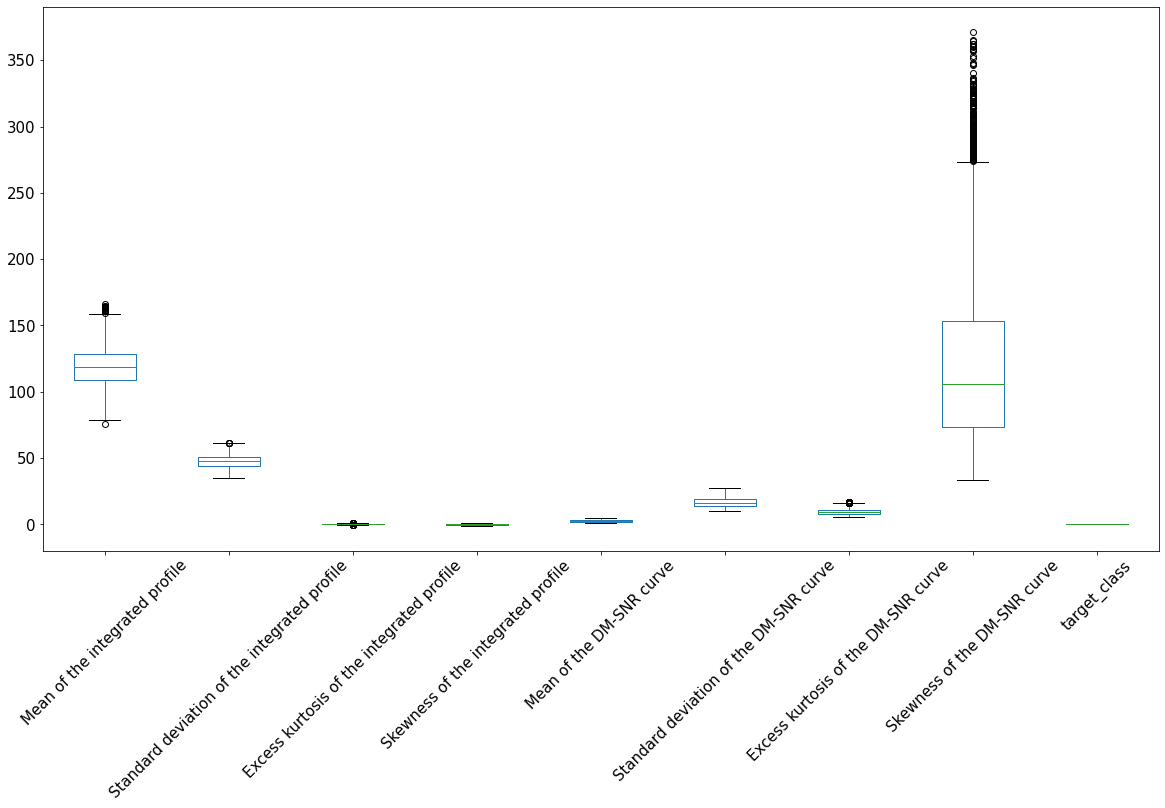

In [28]:
df_if = ((df['target_class'] == 0)&
         (df['Mean of the integrated profile']>64)&
         (df['Standard deviation of the integrated profile']>32.5)&
         (df['Standard deviation of the integrated profile']<61.5)&
         (df['Excess kurtosis of the integrated profile']>-0.64)&
         (df['Excess kurtosis of the integrated profile']<0.97)&
         (df['Skewness of the integrated profile']>-1.7)&
         (df['Skewness of the integrated profile']<1.436)&
         (df['Mean of the DM-SNR curve']<4.86)&
         (df['Standard deviation of the DM-SNR curve']<27.8)&
         (df['Excess kurtosis of the DM-SNR curve']>1.8)&
         (df['Excess kurtosis of the DM-SNR curve']<16.7))

print('Количество строчек:',len(df[df_if]))
df[df_if].boxplot(grid=False,figsize=(20,10),rot=45,fontsize=15)

Количество строчек: 5166


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Skewness of the DM-SNR curve'>

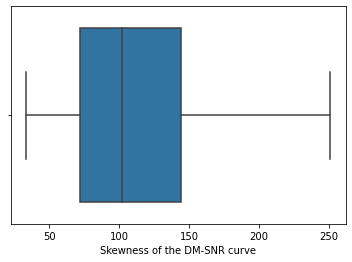

In [29]:
df_if = ((df['target_class'] == 0)&
         (df['Skewness of the DM-SNR curve']<251)&
         (df['Mean of the integrated profile']>64)&
         (df['Standard deviation of the integrated profile']>32.5)&
         (df['Standard deviation of the integrated profile']<61.5)&
         (df['Excess kurtosis of the integrated profile']>-0.64)&
         (df['Excess kurtosis of the integrated profile']<0.97)&
         (df['Skewness of the integrated profile']>-1.7)&
         (df['Skewness of the integrated profile']<1.436)&
         (df['Mean of the DM-SNR curve']<4.86)&
         (df['Standard deviation of the DM-SNR curve']<27.8)&
         (df['Excess kurtosis of the DM-SNR curve']>1.8)&
         (df['Excess kurtosis of the DM-SNR curve']<16.7))

print('Количество строчек:',len(df[df_if]))
sns.boxplot(df[df_if]['Skewness of the DM-SNR curve'])

In [30]:
df_mean = df[df_if]['Skewness of the DM-SNR curve'].describe().T[1]

In [31]:
df['Skewness of the DM-SNR curve']\
[(df['Skewness of the DM-SNR curve'].isnull())&
 (df['target_class'] == 0)] = df_mean

In [32]:
len(df[(df['Skewness of the DM-SNR curve'].isnull())&(df['target_class'] == 0)])

0

In [33]:
df.isnull().sum()

Mean of the integrated profile                     0
Standard deviation of the integrated profile       0
Excess kurtosis of the integrated profile       1730
Skewness of the integrated profile                 0
Mean of the DM-SNR curve                           0
Standard deviation of the DM-SNR curve          1173
Excess kurtosis of the DM-SNR curve                0
Skewness of the DM-SNR curve                      60
target_class                                       0
dtype: int64

<AxesSubplot:>

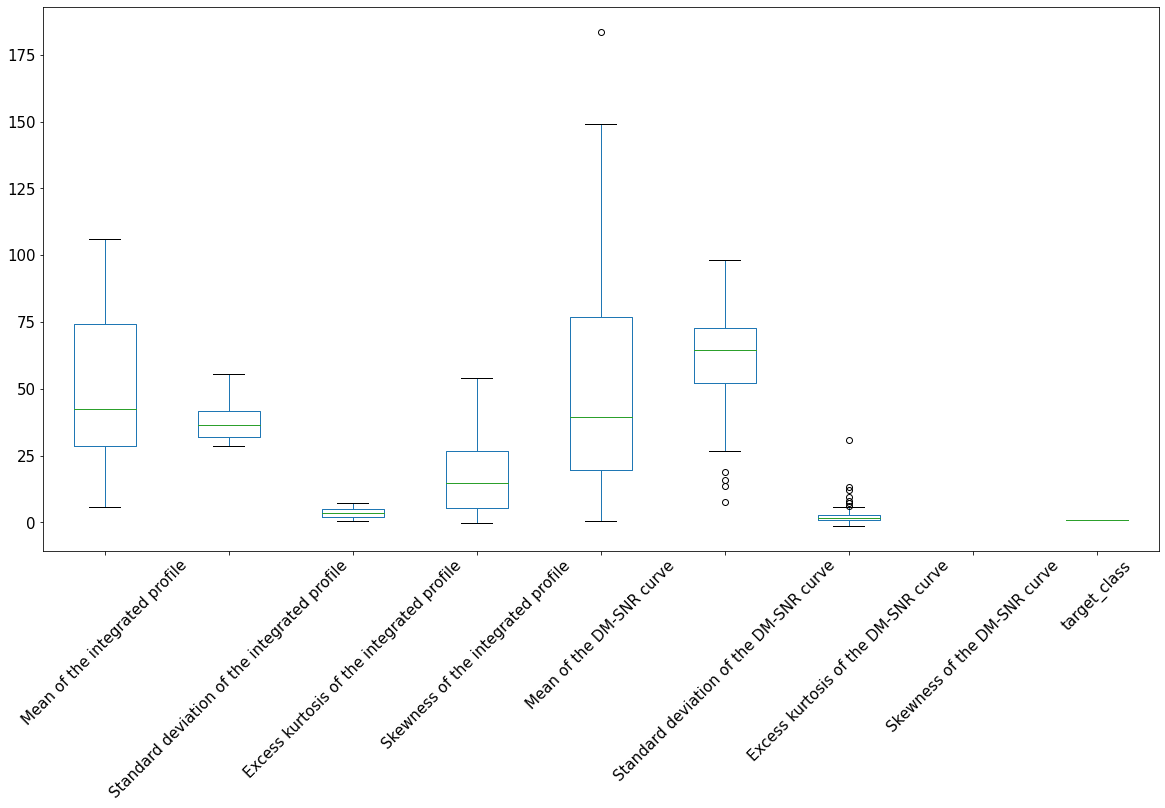

In [34]:
df_if = ((df['Skewness of the DM-SNR curve'].isnull())&
         (df['target_class']==1))

df[df_if].boxplot(grid=False,figsize=(20,10),
                  rot=45,fontsize=15)

In [35]:
df[df_if].describe().T

,count,mean,std,min,25%,50%,75%,max
Mean of the integrated profile,60.0,50.337760,27.163844,5.812500,28.582031,42.367188,74.214844,106.046875
Standard deviation of the integrated profile,60.0,37.939724,7.339981,28.467841,31.778705,36.627399,41.722940,55.624965
Excess kurtosis of the integrated profile,55.0,3.481187,1.894369,0.453628,1.891059,3.490424,4.885743,7.377865
Skewness of the integrated profile,60.0,17.681373,14.534497,-0.406631,5.435076,14.909678,26.879379,54.204981
Mean of the DM-SNR curve,60.0,52.697032,42.148620,0.486622,19.490803,39.286789,76.932901,183.622910
Standard deviation of the DM-SNR curve,54.0,60.353246,19.585020,7.658623,52.165773,64.332429,72.797834,98.196477
Excess kurtosis of the DM-SNR curve,60.0,2.823450,4.617639,-1.326647,0.770290,1.684803,2.845455,30.883882
Skewness of the DM-SNR curve,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target_class,60.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Excess kurtosis of the DM-SNR curve'>

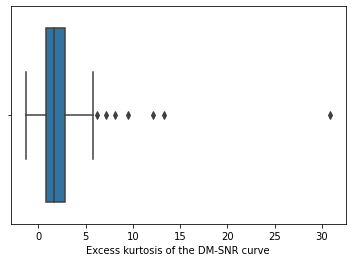

In [36]:
sns.boxplot(df[df_if]['Excess kurtosis of the DM-SNR curve'])

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Standard deviation of the DM-SNR curve'>

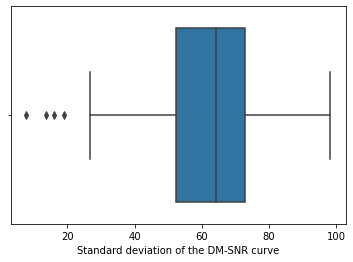

In [37]:
sns.boxplot(df[df_if]['Standard deviation of the DM-SNR curve'])

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Mean of the DM-SNR curve'>

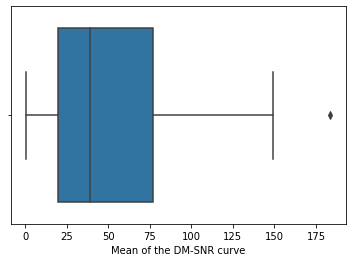

In [38]:
sns.boxplot(df[df_if]['Mean of the DM-SNR curve'])

In [39]:
df_if = ((df['target_class']==1)&
         (df['Mean of the integrated profile']>=5.8125)&
         (df['Mean of the integrated profile']<=106.046875)&
         (df['Standard deviation of the integrated profile']>=28.467841)&
         (df['Standard deviation of the integrated profile']<=55.002698)&
         (df['Excess kurtosis of the integrated profile']>=0.453628)&
         (df['Excess kurtosis of the integrated profile']<=7.377865)&
         (df['Skewness of the integrated profile']>=-0.406631)&
         (df['Skewness of the integrated profile']<=54.204981)&
         (df['Mean of the DM-SNR curve']>=10.140468)&
         (df['Mean of the DM-SNR curve']<=149.070234)&
         (df['Standard deviation of the DM-SNR curve']>=33.996089)&
         (df['Standard deviation of the DM-SNR curve']<=98.196477)&
         (df['Excess kurtosis of the DM-SNR curve']>=-0.289141)&
         (df['Excess kurtosis of the DM-SNR curve']<=4.112380))

In [40]:
df[df_if].describe().T

,count,mean,std,min,25%,50%,75%,max
Mean of the integrated profile,572.0,48.322252,24.333295,6.187500,29.283203,45.410156,65.099609,106.046875
Standard deviation of the integrated profile,572.0,36.885806,6.187452,28.481695,31.594333,35.843991,40.690170,54.947418
Excess kurtosis of the integrated profile,572.0,3.588485,1.576102,0.453628,2.235573,3.648752,4.795167,7.268593
Skewness of the integrated profile,572.0,17.899931,12.128709,-0.406631,7.680490,15.979260,26.410206,53.241153
Mean of the DM-SNR curve,572.0,55.839747,36.685497,10.140468,23.800794,45.210702,85.250209,148.869565
Standard deviation of the DM-SNR curve,572.0,63.915393,12.441698,36.374855,54.749210,64.161794,73.117739,97.176988
Excess kurtosis of the DM-SNR curve,572.0,1.623822,1.148749,-0.289141,0.664985,1.477737,2.492798,4.106325
Skewness of the DM-SNR curve,533.0,3.108359,4.573863,-1.714327,-0.431599,1.182928,5.527676,16.383692
target_class,572.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [41]:
df_if = ((df['target_class']==1)&
         (df['Mean of the integrated profile']>=5.8125)&
         (df['Mean of the integrated profile']<=106.046875)&
         (df['Standard deviation of the integrated profile']>=28.467841)&
         (df['Standard deviation of the integrated profile']<=55.002698)&
         (df['Excess kurtosis of the integrated profile']>=0.453628)&
         (df['Excess kurtosis of the integrated profile']<=7.377865)&
         (df['Skewness of the integrated profile']>=-0.406631)&
         (df['Skewness of the integrated profile']<=54.204981)&
         (df['Mean of the DM-SNR curve']>=10.140468)&
         (df['Mean of the DM-SNR curve']<=149.070234)&
         (df['Standard deviation of the DM-SNR curve']>=33.996089)&
         (df['Standard deviation of the DM-SNR curve']<=98.196477)&
         (df['Excess kurtosis of the DM-SNR curve']>=-0.289141)&
         (df['Excess kurtosis of the DM-SNR curve']<=4.112380)&
         (df['Skewness of the DM-SNR curve']<=12))

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Skewness of the DM-SNR curve'>

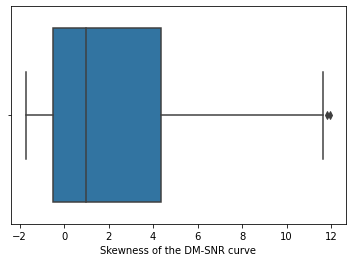

In [42]:
sns.boxplot(df[df_if]['Skewness of the DM-SNR curve'])

In [43]:
df_mean = df[df_if]['Skewness of the DM-SNR curve'].describe().T[1]

In [44]:
df['Skewness of the DM-SNR curve']\
[df['Skewness of the DM-SNR curve'].isnull()] = df_mean

In [45]:
len(df[df['Skewness of the DM-SNR curve'].isnull()])

0

Убераем nan в табличе "Standard deviation of the DM-SNR curve" c "target_class" = 0

In [46]:
df.isnull().sum()

Mean of the integrated profile                     0
Standard deviation of the integrated profile       0
Excess kurtosis of the integrated profile       1730
Skewness of the integrated profile                 0
Mean of the DM-SNR curve                           0
Standard deviation of the DM-SNR curve          1173
Excess kurtosis of the DM-SNR curve                0
Skewness of the DM-SNR curve                       0
target_class                                       0
dtype: int64

In [47]:
df_if = ((df['Standard deviation of the DM-SNR curve'].isnull())&
         (df['target_class']==0))
len(df[df_if])

1070

<AxesSubplot:>

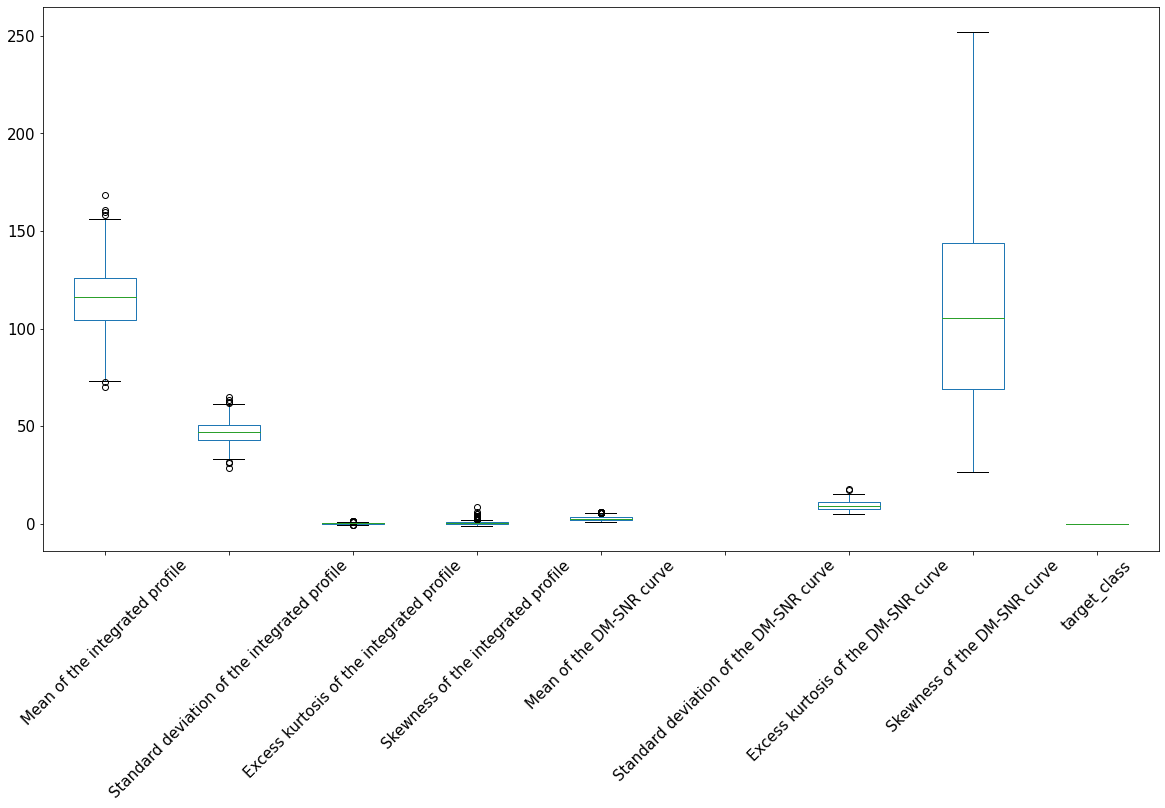

In [48]:
df_if = ((df['Standard deviation of the DM-SNR curve'].isnull())&
         (df['target_class']==0)&
         (df['Skewness of the DM-SNR curve']<258)&
         (df['Mean of the DM-SNR curve']<6))

df[df_if].boxplot(grid=False,figsize=(20,10),
                  rot=45,fontsize=15)

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Skewness of the DM-SNR curve'>

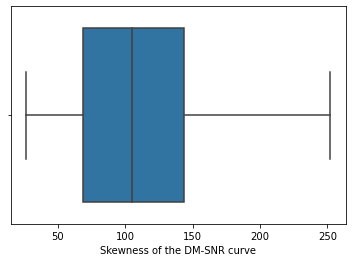

In [49]:
sns.boxplot(df[df_if]['Skewness of the DM-SNR curve'])

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Mean of the DM-SNR curve'>

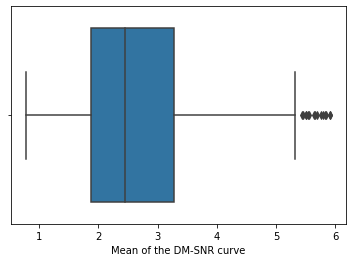

In [50]:
sns.boxplot(df[df_if]['Mean of the DM-SNR curve'])

In [51]:
df_m_p_n = df[df_if]['Mean of the integrated profile'].describe().T[3]
df_m_p_x = df[df_if]['Mean of the integrated profile'].describe().T[7]
df_s_p_n = df[df_if]['Standard deviation of the integrated profile'].describe().T[3]
df_s_p_x = df[df_if]['Standard deviation of the integrated profile'].describe().T[7]
df_e_p_n = df[df_if]['Excess kurtosis of the integrated profile'].describe().T[3]
df_e_p_x = df[df_if]['Excess kurtosis of the integrated profile'].describe().T[7]
df_sk_p_n = df[df_if]['Skewness of the integrated profile'].describe().T[3]
df_sk_p_x = df[df_if]['Skewness of the integrated profile'].describe().T[7]
df_m_c_n = df[df_if]['Mean of the DM-SNR curve'].describe().T[3]
df_m_c_x = df[df_if]['Mean of the DM-SNR curve'].describe().T[7]
df_e_c_n = df[df_if]['Excess kurtosis of the DM-SNR curve'].describe().T[3]
df_e_c_x = df[df_if]['Excess kurtosis of the DM-SNR curve'].describe().T[7]
df_sk_c_n = df[df_if]['Skewness of the DM-SNR curve'].describe().T[3]
df_sk_c_x = df[df_if]['Skewness of the DM-SNR curve'].describe().T[7]

<AxesSubplot:>

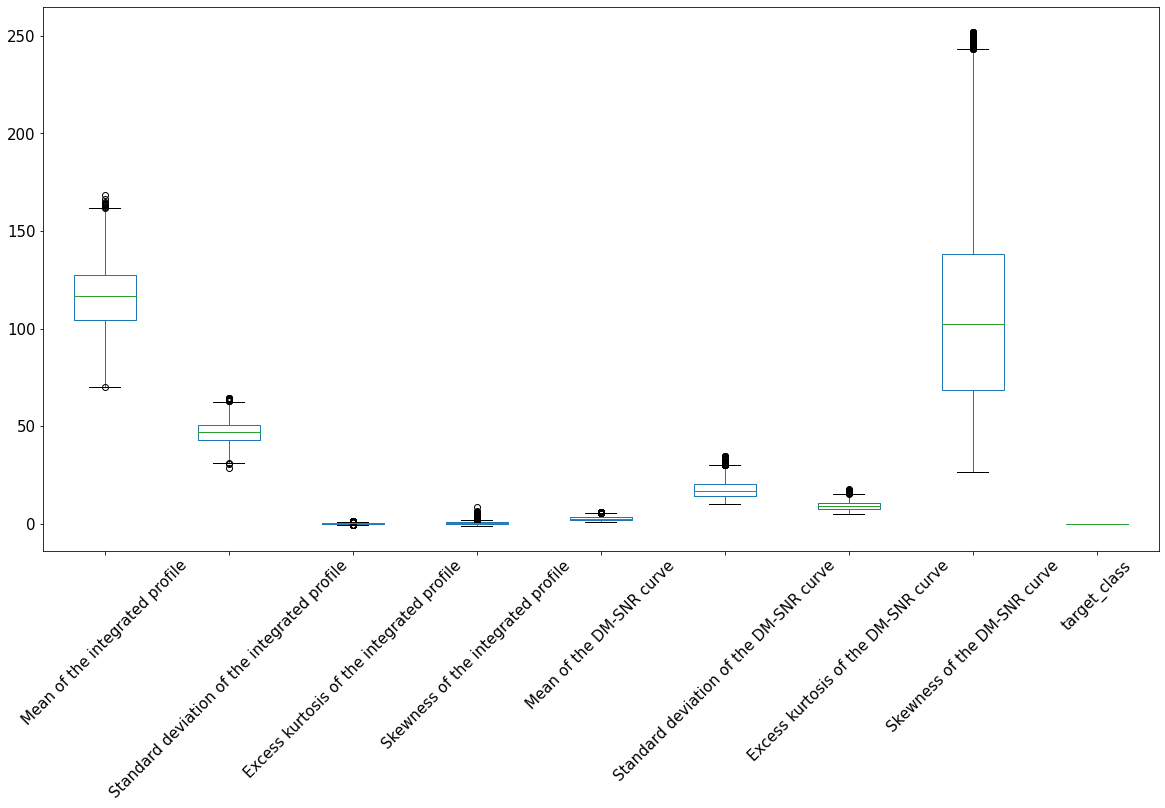

In [52]:
df_if = ((df['target_class']==0)&
         (df['Mean of the integrated profile']>=df_m_p_n)&
         (df['Mean of the integrated profile']<=df_m_p_x)&
         (df['Standard deviation of the integrated profile']>=df_s_p_n)&
         (df['Standard deviation of the integrated profile']<=df_s_p_x)&
         (df['Excess kurtosis of the integrated profile']>=df_e_p_n)&
         (df['Excess kurtosis of the integrated profile']<=df_e_p_x)&
         (df['Skewness of the integrated profile']>=df_sk_p_n)&
         (df['Skewness of the integrated profile']<=df_sk_p_x)&
         (df['Mean of the DM-SNR curve']>=df_m_c_n)&
         (df['Mean of the DM-SNR curve']<=df_m_c_x)&
         (df['Excess kurtosis of the DM-SNR curve']>=df_e_c_n)&
         (df['Excess kurtosis of the DM-SNR curve']<=df_e_c_x)&
         (df['Skewness of the DM-SNR curve']>=df_sk_c_n)&
         (df['Skewness of the DM-SNR curve']<=df_sk_c_x))

df[df_if].boxplot(grid=False,figsize=(20,10),
                  rot=45,fontsize=15)

In [53]:
df[df_if].describe().T

,count,mean,std,min,25%,50%,75%,max
Mean of the integrated profile,7310.0,115.742191,16.537249,70.156250,104.556641,116.500000,127.429688,168.273438
Standard deviation of the integrated profile,7310.0,46.771723,5.671649,28.698714,42.978751,47.005674,50.810282,64.676063
Excess kurtosis of the integrated profile,7310.0,0.223663,0.283486,-0.729545,0.022548,0.202138,0.403590,1.511090
Skewness of the integrated profile,7310.0,0.405530,0.902746,-1.135840,-0.191152,0.163273,0.702278,8.367704
Mean of the DM-SNR curve,7310.0,2.689187,1.074585,0.775920,1.894649,2.467391,3.276756,5.915552
Standard deviation of the DM-SNR curve,6614.0,17.838249,4.557704,10.041889,14.292881,16.835388,20.590242,34.893584
Excess kurtosis of the DM-SNR curve,7310.0,9.338576,2.189960,4.914792,7.673635,9.122499,10.785786,17.636520
Skewness of the DM-SNR curve,7310.0,108.870791,51.672125,26.461769,68.398195,102.116877,138.320876,252.097256
target_class,7310.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Standard deviation of the DM-SNR curve'>

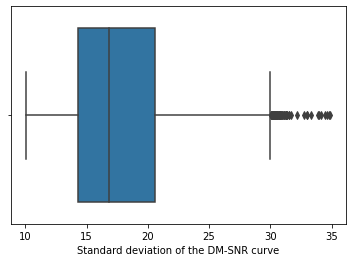

In [54]:
sns.boxplot(df[df_if]['Standard deviation of the DM-SNR curve'])

In [55]:
df_if = ((df['target_class']==0)&
         (df['Mean of the integrated profile']>=df_m_p_n)&
         (df['Mean of the integrated profile']<=df_m_p_x)&
         (df['Standard deviation of the integrated profile']>=df_s_p_n)&
         (df['Standard deviation of the integrated profile']<=df_s_p_x)&
         (df['Excess kurtosis of the integrated profile']>=df_e_p_n)&
         (df['Excess kurtosis of the integrated profile']<=df_e_p_x)&
         (df['Skewness of the integrated profile']>=df_sk_p_n)&
         (df['Skewness of the integrated profile']<=df_sk_p_x)&
         (df['Mean of the DM-SNR curve']>=df_m_c_n)&
         (df['Mean of the DM-SNR curve']<=df_m_c_x)&
         (df['Excess kurtosis of the DM-SNR curve']>=df_e_c_n)&
         (df['Excess kurtosis of the DM-SNR curve']<=df_e_c_x)&
         (df['Skewness of the DM-SNR curve']>=df_sk_c_n)&
         (df['Skewness of the DM-SNR curve']<=df_sk_c_x)&
         (df['Standard deviation of the DM-SNR curve']<=29.5))

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Standard deviation of the DM-SNR curve'>

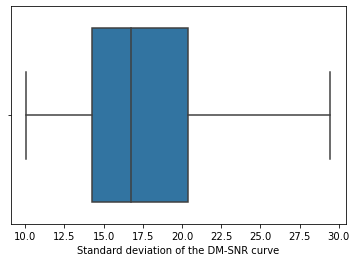

In [56]:
sns.boxplot(df[df_if]['Standard deviation of the DM-SNR curve'])

In [57]:
df_mean = df[df_if]['Standard deviation of the DM-SNR curve'].describe().T[1]

In [58]:
df['Standard deviation of the DM-SNR curve']\
[((df['Standard deviation of the DM-SNR curve'].isnull())&
  (df['target_class']==0))] = df_mean

In [59]:
len(df[(df['Standard deviation of the DM-SNR curve'].isnull())&
       (df['target_class']==0)])

0

Убераем nan в табличе "Standard deviation of the DM-SNR curve" c "target_class" = 1

In [60]:
df.isnull().sum()

Mean of the integrated profile                     0
Standard deviation of the integrated profile       0
Excess kurtosis of the integrated profile       1730
Skewness of the integrated profile                 0
Mean of the DM-SNR curve                           0
Standard deviation of the DM-SNR curve           103
Excess kurtosis of the DM-SNR curve                0
Skewness of the DM-SNR curve                       0
target_class                                       0
dtype: int64

In [61]:
df_if = ((df['Standard deviation of the DM-SNR curve'].isnull())&
         (df['target_class']==1))
len(df[df_if])

103

In [62]:
df_if = ((df['Standard deviation of the DM-SNR curve'].isnull())&
         (df['target_class']==1)&
         (df['Skewness of the DM-SNR curve']<=30)&
         (df['Mean of the DM-SNR curve']<=140))
len(df[df_if])

81

<AxesSubplot:>

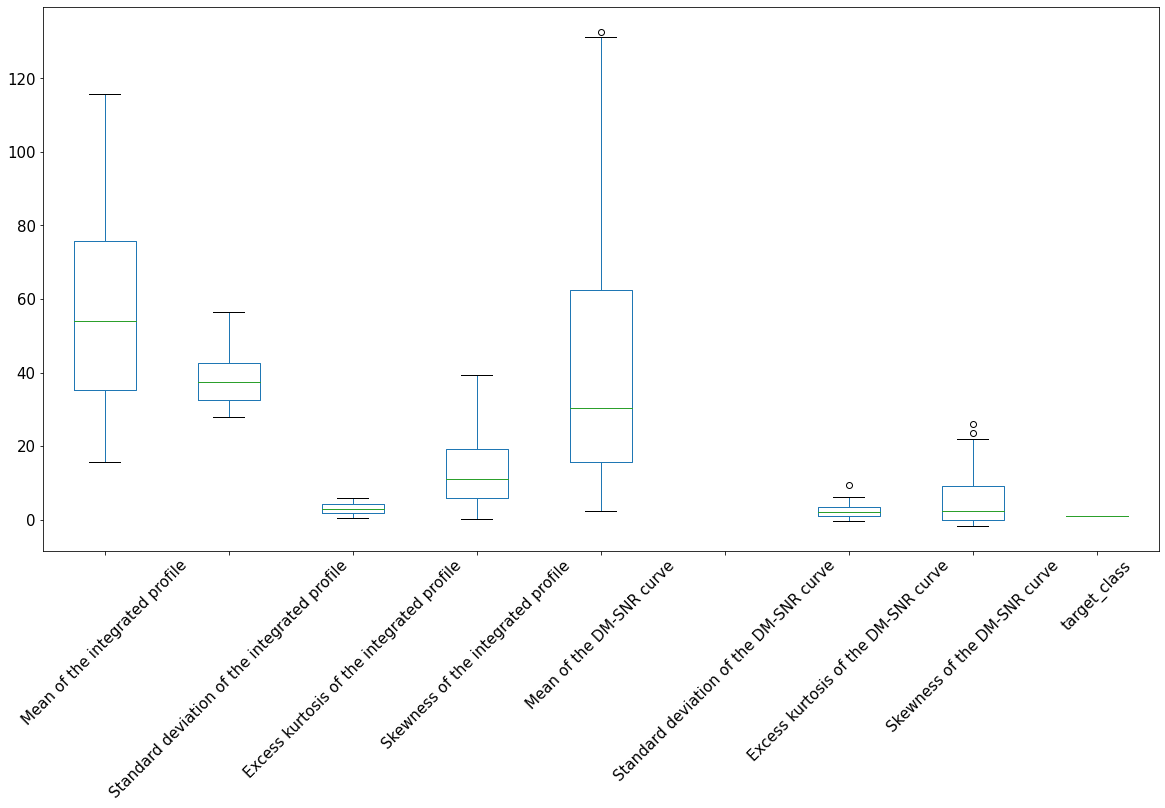

In [63]:
df[df_if].boxplot(grid=False,figsize=(20,10),
                  rot=45,fontsize=15)

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Skewness of the DM-SNR curve'>

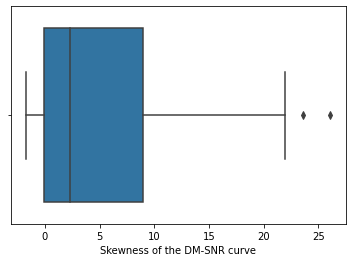

In [64]:
sns.boxplot(df[df_if]['Skewness of the DM-SNR curve'])

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Mean of the DM-SNR curve'>

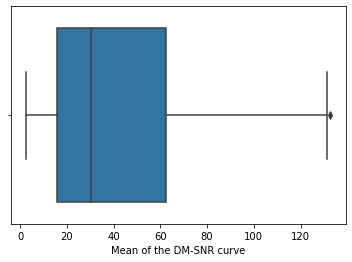

In [65]:
sns.boxplot(df[df_if]['Mean of the DM-SNR curve'])

In [66]:
df[df_if].describe().T

,count,mean,std,min,25%,50%,75%,max
Mean of the integrated profile,81.0,57.172357,25.996632,15.617188,35.265625,54.007812,75.726562,115.687500
Standard deviation of the integrated profile,81.0,38.067868,6.535856,28.011572,32.460790,37.463732,42.521844,56.453069
Excess kurtosis of the integrated profile,77.0,2.987447,1.542177,0.442356,1.789568,2.833535,4.106637,5.933759
Skewness of the integrated profile,81.0,14.153713,10.967183,0.084257,5.739770,11.032994,19.294670,39.447852
Mean of the DM-SNR curve,81.0,44.189665,36.482901,2.382943,15.684783,30.326087,62.463211,132.695652
Standard deviation of the DM-SNR curve,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Excess kurtosis of the DM-SNR curve,81.0,2.227249,1.699627,-0.506662,0.913483,1.932782,3.338828,9.493185
Skewness of the DM-SNR curve,81.0,5.388166,7.042518,-1.731313,-0.049028,2.307562,9.012004,26.092923
target_class,81.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [67]:
df_m_p_n = df[df_if]['Mean of the integrated profile'].describe().T[3]
df_m_p_x = df[df_if]['Mean of the integrated profile'].describe().T[7]
df_s_p_n = df[df_if]['Standard deviation of the integrated profile'].describe().T[3]
df_s_p_x = df[df_if]['Standard deviation of the integrated profile'].describe().T[7]
df_e_p_n = df[df_if]['Excess kurtosis of the integrated profile'].describe().T[3]
df_e_p_x = df[df_if]['Excess kurtosis of the integrated profile'].describe().T[7]
df_sk_p_n = df[df_if]['Skewness of the integrated profile'].describe().T[3]
df_sk_p_x = df[df_if]['Skewness of the integrated profile'].describe().T[7]
df_m_c_n = df[df_if]['Mean of the DM-SNR curve'].describe().T[3]
df_m_c_x = df[df_if]['Mean of the DM-SNR curve'].describe().T[7]
df_e_c_n = df[df_if]['Excess kurtosis of the DM-SNR curve'].describe().T[3]
df_e_c_x = df[df_if]['Excess kurtosis of the DM-SNR curve'].describe().T[7]
df_sk_c_n = df[df_if]['Skewness of the DM-SNR curve'].describe().T[3]
df_sk_c_x = df[df_if]['Skewness of the DM-SNR curve'].describe().T[7]

In [68]:
df_if = ((df['target_class']==1)&
         (df['Mean of the integrated profile']>=df_m_p_n)&
         (df['Mean of the integrated profile']<=df_m_p_x)&
         (df['Standard deviation of the integrated profile']>=df_s_p_n)&
         (df['Standard deviation of the integrated profile']<=df_s_p_x)&
         (df['Excess kurtosis of the integrated profile']>=df_e_p_n)&
         (df['Excess kurtosis of the integrated profile']<=df_e_p_x)&
         (df['Skewness of the integrated profile']>=df_sk_p_n)&
         (df['Skewness of the integrated profile']<=df_sk_p_x)&
         (df['Mean of the DM-SNR curve']>=df_m_c_n)&
         (df['Mean of the DM-SNR curve']<=df_m_c_x)&
         (df['Excess kurtosis of the DM-SNR curve']>=df_e_c_n)&
         (df['Excess kurtosis of the DM-SNR curve']<=df_e_c_x)&
         (df['Skewness of the DM-SNR curve']>=df_sk_c_n)&
         (df['Skewness of the DM-SNR curve']<=df_sk_c_x)&
         (df['Standard deviation of the DM-SNR curve']<=107))
len(df[df_if])

547

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Standard deviation of the DM-SNR curve'>

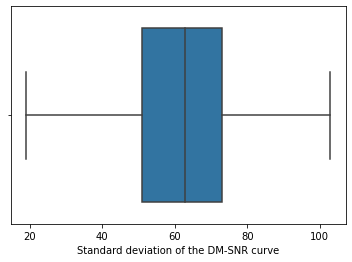

In [69]:
sns.boxplot(df[df_if]['Standard deviation of the DM-SNR curve'])

In [70]:
df_mean = df[df_if]['Standard deviation of the DM-SNR curve'].describe().T[1]

In [71]:
df['Standard deviation of the DM-SNR curve']\
[df['Standard deviation of the DM-SNR curve'].isnull()] = df_mean

In [72]:
len(df['Standard deviation of the DM-SNR curve']
[df['Standard deviation of the DM-SNR curve'].isnull()])

0

Убераем nan в табличе "Excess kurtosis of the integrated profile" c "target_class" = 0

In [73]:
df.isnull().sum()

Mean of the integrated profile                     0
Standard deviation of the integrated profile       0
Excess kurtosis of the integrated profile       1730
Skewness of the integrated profile                 0
Mean of the DM-SNR curve                           0
Standard deviation of the DM-SNR curve             0
Excess kurtosis of the DM-SNR curve                0
Skewness of the DM-SNR curve                       0
target_class                                       0
dtype: int64

In [74]:
df_if = ((df['Excess kurtosis of the integrated profile'].isnull())&
         (df['target_class']==0))
len(df[df_if])

1574

In [75]:
df_if = ((df['Excess kurtosis of the integrated profile'].isnull())&
         (df['target_class']==0)&
         (df['Skewness of the DM-SNR curve']<=250)&
         (df['Mean of the DM-SNR curve']<=10)&
         (df['Standard deviation of the DM-SNR curve']<=33)&
         (df['Standard deviation of the integrated profile']<=60)&
         (df['Standard deviation of the integrated profile']>33)&
         (df['Mean of the integrated profile']<=161)&
         (df['Mean of the integrated profile']>70)&
         (df['Excess kurtosis of the DM-SNR curve']<16))
len(df[df_if])

1238

<AxesSubplot:>

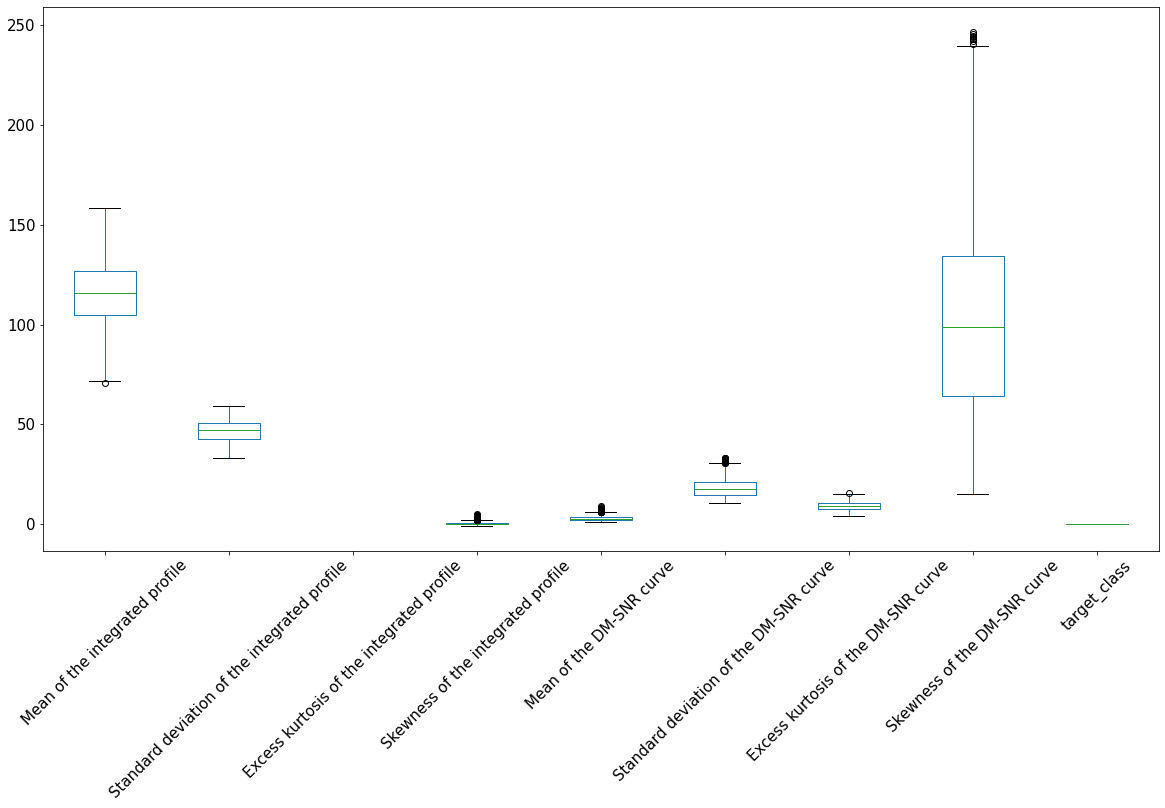

In [76]:
df[df_if].boxplot(grid=False,figsize=(20,10),
                  rot=45,fontsize=15)

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Standard deviation of the DM-SNR curve'>

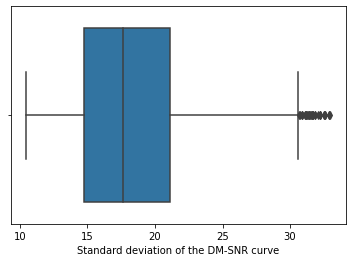

In [77]:
sns.boxplot(df[df_if]['Standard deviation of the DM-SNR curve'])

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Mean of the DM-SNR curve'>

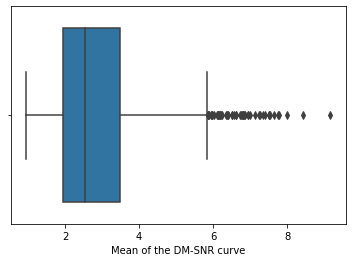

In [78]:
sns.boxplot(df[df_if]['Mean of the DM-SNR curve'])

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Standard deviation of the integrated profile'>

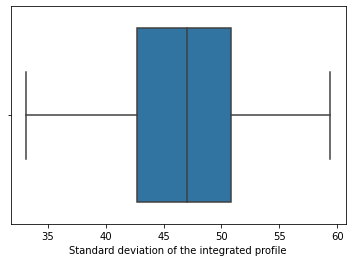

In [79]:
sns.boxplot(df[df_if]['Standard deviation of the integrated profile'])

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Mean of the integrated profile'>

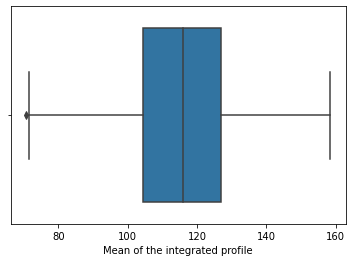

In [80]:
sns.boxplot(df[df_if]['Mean of the integrated profile'])

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Excess kurtosis of the DM-SNR curve'>

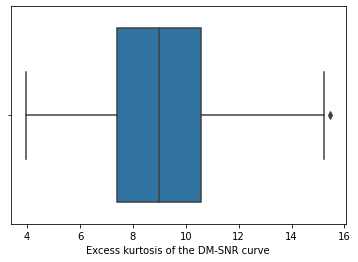

In [81]:
sns.boxplot(df[df_if]['Excess kurtosis of the DM-SNR curve'])

In [82]:
df_m_p_n = df[df_if]['Mean of the integrated profile'].describe().T[3]
df_m_p_x = df[df_if]['Mean of the integrated profile'].describe().T[7]
df_s_p_n = df[df_if]['Standard deviation of the integrated profile'].describe().T[3]
df_s_p_x = df[df_if]['Standard deviation of the integrated profile'].describe().T[7]
df_sk_p_n = df[df_if]['Skewness of the integrated profile'].describe().T[3]
df_sk_p_x = df[df_if]['Skewness of the integrated profile'].describe().T[7]
df_m_c_n = df[df_if]['Mean of the DM-SNR curve'].describe().T[3]
df_m_c_x = df[df_if]['Mean of the DM-SNR curve'].describe().T[7]
df_e_c_n = df[df_if]['Excess kurtosis of the DM-SNR curve'].describe().T[3]
df_e_c_x = df[df_if]['Excess kurtosis of the DM-SNR curve'].describe().T[7]
df_sk_c_n = df[df_if]['Skewness of the DM-SNR curve'].describe().T[3]
df_sk_c_x = df[df_if]['Skewness of the DM-SNR curve'].describe().T[7]
df_s_c_n = df[df_if]['Standard deviation of the DM-SNR curve'].describe().T[3]
df_s_c_x = df[df_if]['Standard deviation of the DM-SNR curve'].describe().T[7]
df[df_if].describe().T

,count,mean,std,min,25%,50%,75%,max
Mean of the integrated profile,1238.0,115.498504,16.431577,70.671875,104.564453,115.964844,126.783203,158.429688
Standard deviation of the integrated profile,1238.0,46.666736,5.562350,33.117861,42.721949,47.015211,50.865354,59.402185
Excess kurtosis of the integrated profile,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Skewness of the integrated profile,1238.0,0.408290,0.873176,-0.950975,-0.187028,0.161411,0.701033,5.057367
Mean of the DM-SNR curve,1238.0,2.878661,1.330899,0.938127,1.935201,2.547241,3.492475,9.164716
Standard deviation of the DM-SNR curve,1238.0,18.427042,4.865950,10.447506,14.783336,17.644264,21.115038,32.975129
Excess kurtosis of the DM-SNR curve,1238.0,9.091652,2.233559,3.956542,7.388621,8.978199,10.568616,15.463692
Skewness of the DM-SNR curve,1238.0,103.342890,50.084701,14.992174,64.177029,98.524743,134.391085,246.742747
target_class,1238.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


7338


<AxesSubplot:>

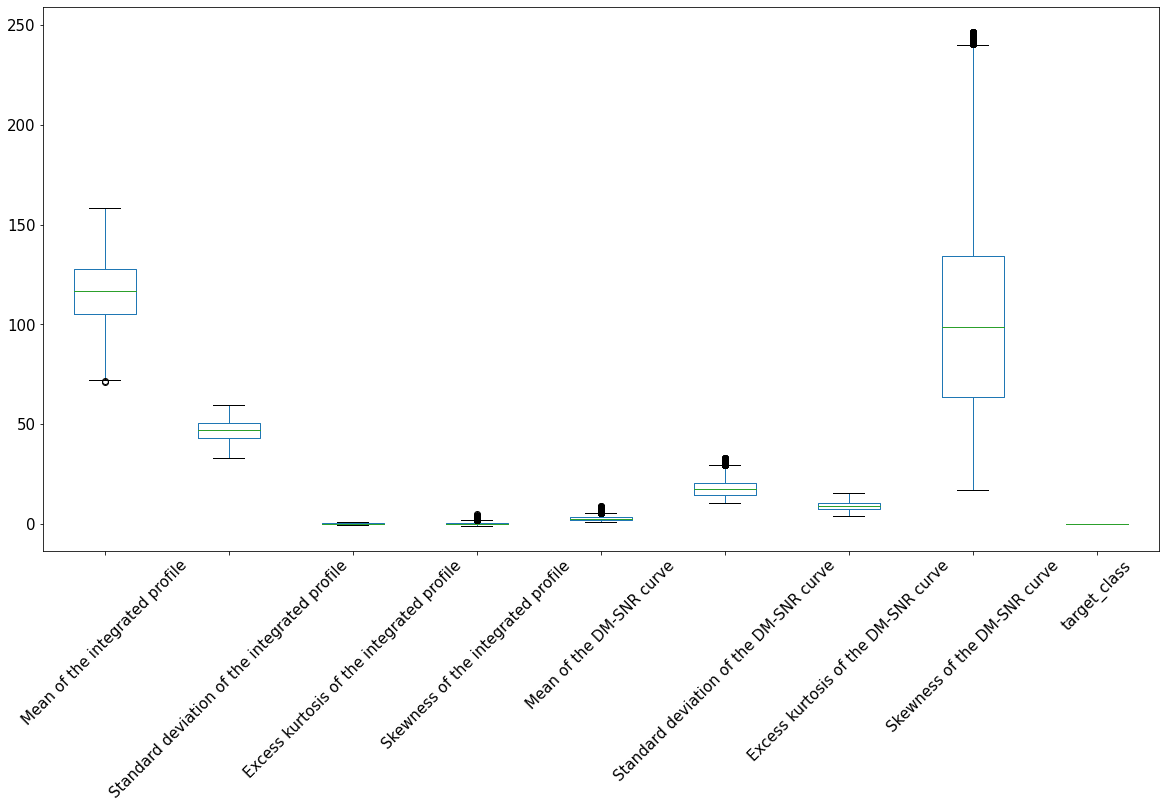

In [83]:
df_if = ((df['target_class']==0)&
         (df['Mean of the integrated profile']>=df_m_p_n)&
         (df['Mean of the integrated profile']<=df_m_p_x)&
         (df['Standard deviation of the integrated profile']>=df_s_p_n)&
         (df['Standard deviation of the integrated profile']<=df_s_p_x)&
         (df['Skewness of the integrated profile']>=df_sk_p_n)&
         (df['Skewness of the integrated profile']<=df_sk_p_x)&
         (df['Mean of the DM-SNR curve']>=df_m_c_n)&
         (df['Mean of the DM-SNR curve']<=df_m_c_x)&
         (df['Excess kurtosis of the DM-SNR curve']>=df_e_c_n)&
         (df['Excess kurtosis of the DM-SNR curve']<=df_e_c_x)&
         (df['Skewness of the DM-SNR curve']>=df_sk_c_n)&
         (df['Skewness of the DM-SNR curve']<=df_sk_c_x)&
         (df['Standard deviation of the DM-SNR curve']>=df_s_c_n)&
         (df['Standard deviation of the DM-SNR curve']<=df_s_c_x)&
         (df['Excess kurtosis of the integrated profile']>=-0.555)&
         (df['Excess kurtosis of the integrated profile']<=0.95))
print(len(df[df_if]))
df[df_if].boxplot(grid=False,figsize=(20,10),
                  rot=45,fontsize=15)

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Excess kurtosis of the integrated profile'>

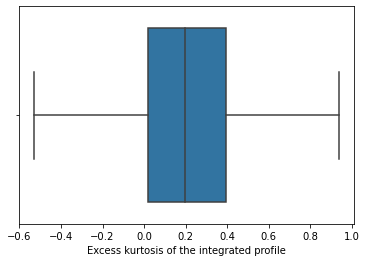

In [84]:
sns.boxplot(df[df_if]['Excess kurtosis of the integrated profile'])

In [85]:
df_mean = df[df_if]['Excess kurtosis of the integrated profile'].describe().T[1]

In [86]:
df['Excess kurtosis of the integrated profile']\
[(df['target_class']==0)&
 (df['Excess kurtosis of the integrated profile'].isnull())] = df_mean

In [87]:
len(df['Excess kurtosis of the integrated profile']\
[(df['target_class']==0)&
 (df['Excess kurtosis of the integrated profile'].isnull())])

0

Убераем nan в табличе "Excess kurtosis of the integrated profile" c "target_class" = 1

In [88]:
df.isnull().sum()

Mean of the integrated profile                    0
Standard deviation of the integrated profile      0
Excess kurtosis of the integrated profile       156
Skewness of the integrated profile                0
Mean of the DM-SNR curve                          0
Standard deviation of the DM-SNR curve            0
Excess kurtosis of the DM-SNR curve               0
Skewness of the DM-SNR curve                      0
target_class                                      0
dtype: int64

In [89]:
df_if = ((df['Excess kurtosis of the integrated profile'].isnull()))
len(df[df_if])

156

In [90]:
df_if = ((df['Excess kurtosis of the integrated profile'].isnull())&
         (df['Skewness of the DM-SNR curve']<=20)&
         (df['Standard deviation of the integrated profile']<=60)&
         (df['Excess kurtosis of the DM-SNR curve']<=6))
len(df[df_if])

127

<AxesSubplot:>

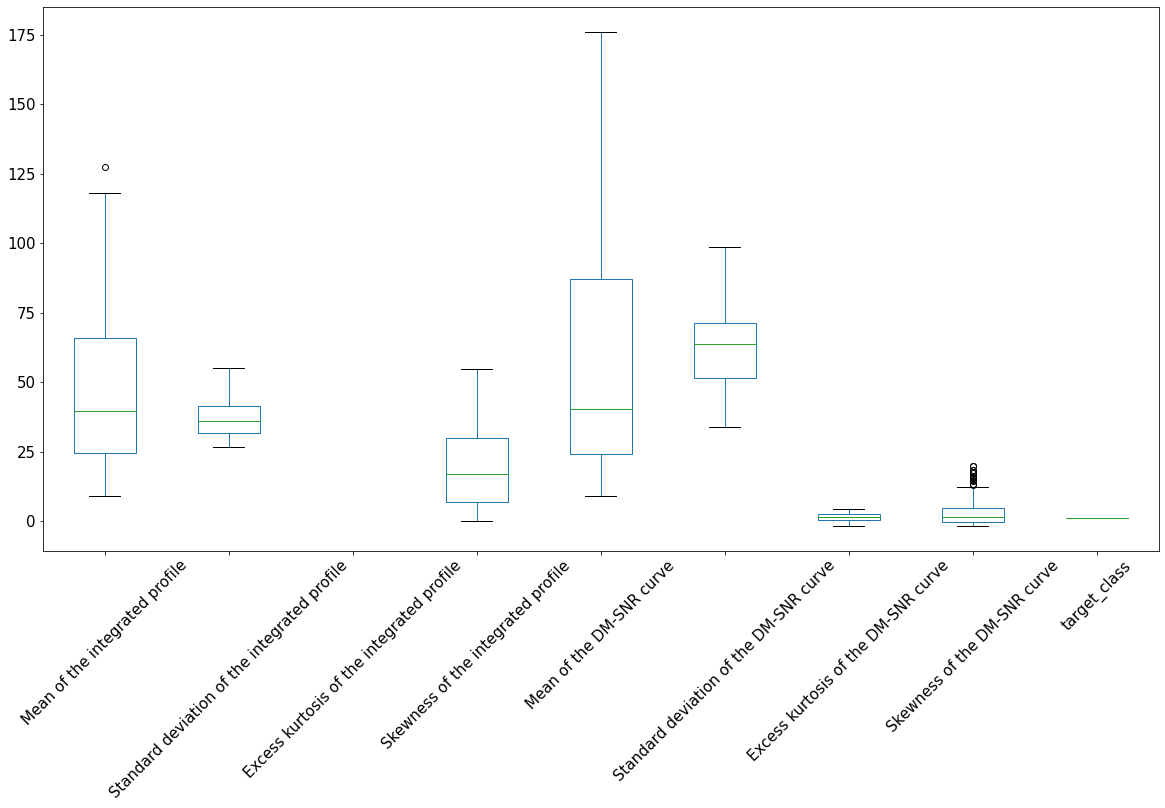

In [91]:
df[df_if].boxplot(grid=False,figsize=(20,10),
                  rot=45,fontsize=15)

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Skewness of the DM-SNR curve'>

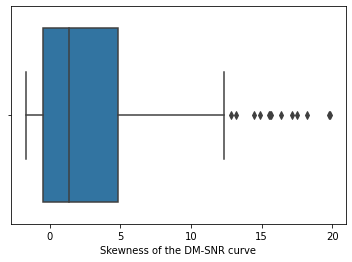

In [92]:
sns.boxplot(df[df_if]['Skewness of the DM-SNR curve'])

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Standard deviation of the integrated profile'>

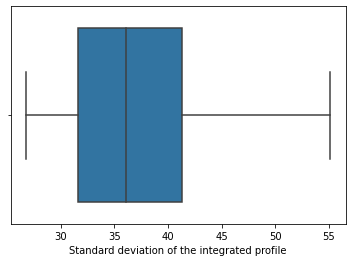

In [93]:
sns.boxplot(df[df_if]['Standard deviation of the integrated profile'])

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Excess kurtosis of the DM-SNR curve'>

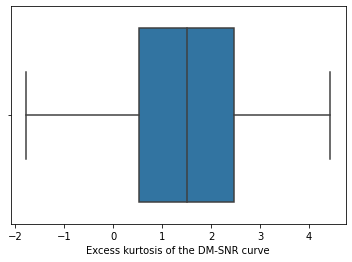

In [94]:
sns.boxplot(df[df_if]['Excess kurtosis of the DM-SNR curve'])

In [95]:
df_m_p_n = df[df_if]['Mean of the integrated profile'].describe().T[3]
df_m_p_x = df[df_if]['Mean of the integrated profile'].describe().T[7]
df_s_p_n = df[df_if]['Standard deviation of the integrated profile'].describe().T[3]
df_s_p_x = df[df_if]['Standard deviation of the integrated profile'].describe().T[7]
df_sk_p_n = df[df_if]['Skewness of the integrated profile'].describe().T[3]
df_sk_p_x = df[df_if]['Skewness of the integrated profile'].describe().T[7]
df_m_c_n = df[df_if]['Mean of the DM-SNR curve'].describe().T[3]
df_m_c_x = df[df_if]['Mean of the DM-SNR curve'].describe().T[7]
df_e_c_n = df[df_if]['Excess kurtosis of the DM-SNR curve'].describe().T[3]
df_e_c_x = df[df_if]['Excess kurtosis of the DM-SNR curve'].describe().T[7]
df_sk_c_n = df[df_if]['Skewness of the DM-SNR curve'].describe().T[3]
df_sk_c_x = df[df_if]['Skewness of the DM-SNR curve'].describe().T[7]
df_s_c_n = df[df_if]['Standard deviation of the DM-SNR curve'].describe().T[3]
df_s_c_x = df[df_if]['Standard deviation of the DM-SNR curve'].describe().T[7]
df[df_if].describe().T

,count,mean,std,min,25%,50%,75%,max
Mean of the integrated profile,127.0,47.273745,27.772298,8.843750,24.480469,39.648438,65.691406,127.570312
Standard deviation of the integrated profile,127.0,37.296240,6.666312,26.776559,31.594521,36.068950,41.279370,55.132023
Excess kurtosis of the integrated profile,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Skewness of the integrated profile,127.0,18.940306,13.773702,-0.048672,6.900170,16.924966,29.981409,54.568664
Mean of the DM-SNR curve,127.0,58.531068,42.232722,8.891304,24.137542,40.449833,86.982860,176.119565
Standard deviation of the DM-SNR curve,127.0,63.059113,14.364045,33.996089,51.516380,63.656462,71.201063,98.462127
Excess kurtosis of the DM-SNR curve,127.0,1.616161,1.357836,-1.785377,0.522549,1.512811,2.456374,4.431190
Skewness of the DM-SNR curve,127.0,3.428618,5.498068,-1.676795,-0.478118,1.369426,4.847712,19.868969
target_class,127.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000


843


<AxesSubplot:>

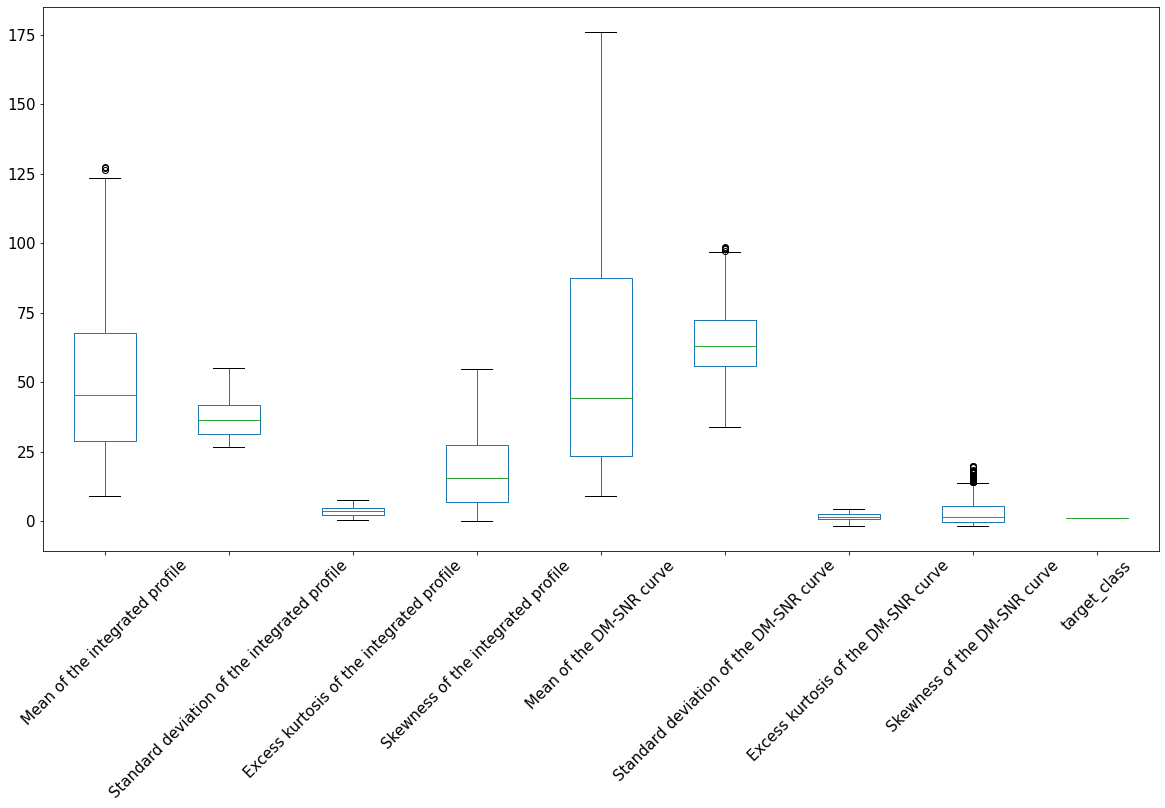

In [96]:
df_if = ((df['target_class']==1)&
         (df['Mean of the integrated profile']>=df_m_p_n)&
         (df['Mean of the integrated profile']<=df_m_p_x)&
         (df['Standard deviation of the integrated profile']>=df_s_p_n)&
         (df['Standard deviation of the integrated profile']<=df_s_p_x)&
         (df['Skewness of the integrated profile']>=df_sk_p_n)&
         (df['Skewness of the integrated profile']<=df_sk_p_x)&
         (df['Mean of the DM-SNR curve']>=df_m_c_n)&
         (df['Mean of the DM-SNR curve']<=df_m_c_x)&
         (df['Excess kurtosis of the DM-SNR curve']>=df_e_c_n)&
         (df['Excess kurtosis of the DM-SNR curve']<=df_e_c_x)&
         (df['Skewness of the DM-SNR curve']>=df_sk_c_n)&
         (df['Skewness of the DM-SNR curve']<=df_sk_c_x)&
         (df['Standard deviation of the DM-SNR curve']>=df_s_c_n)&
         (df['Standard deviation of the DM-SNR curve']<=df_s_c_x))
print(len(df[df_if]))
df[df_if].boxplot(grid=False,figsize=(20,10),
                  rot=45,fontsize=15)

C:\Users\user\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Excess kurtosis of the integrated profile'>

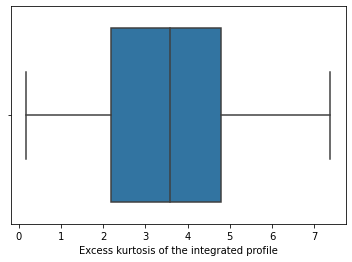

In [97]:
sns.boxplot(df[df_if]['Excess kurtosis of the integrated profile'])

In [98]:
df_mean = df['Excess kurtosis of the integrated profile'][df_if].describe().T[1]

In [99]:
df['Excess kurtosis of the integrated profile']\
[(df['Excess kurtosis of the integrated profile'].isnull())] = df_mean

In [100]:
len(df['Excess kurtosis of the integrated profile']\
[(df['Excess kurtosis of the integrated profile'].isnull())])

0

In [101]:
df.isnull().sum()

Mean of the integrated profile                  0
Standard deviation of the integrated profile    0
Excess kurtosis of the integrated profile       0
Skewness of the integrated profile              0
Mean of the DM-SNR curve                        0
Standard deviation of the DM-SNR curve          0
Excess kurtosis of the DM-SNR curve             0
Skewness of the DM-SNR curve                    0
target_class                                    0
dtype: int64

Результаты, после работы с nan значениями

<AxesSubplot:>

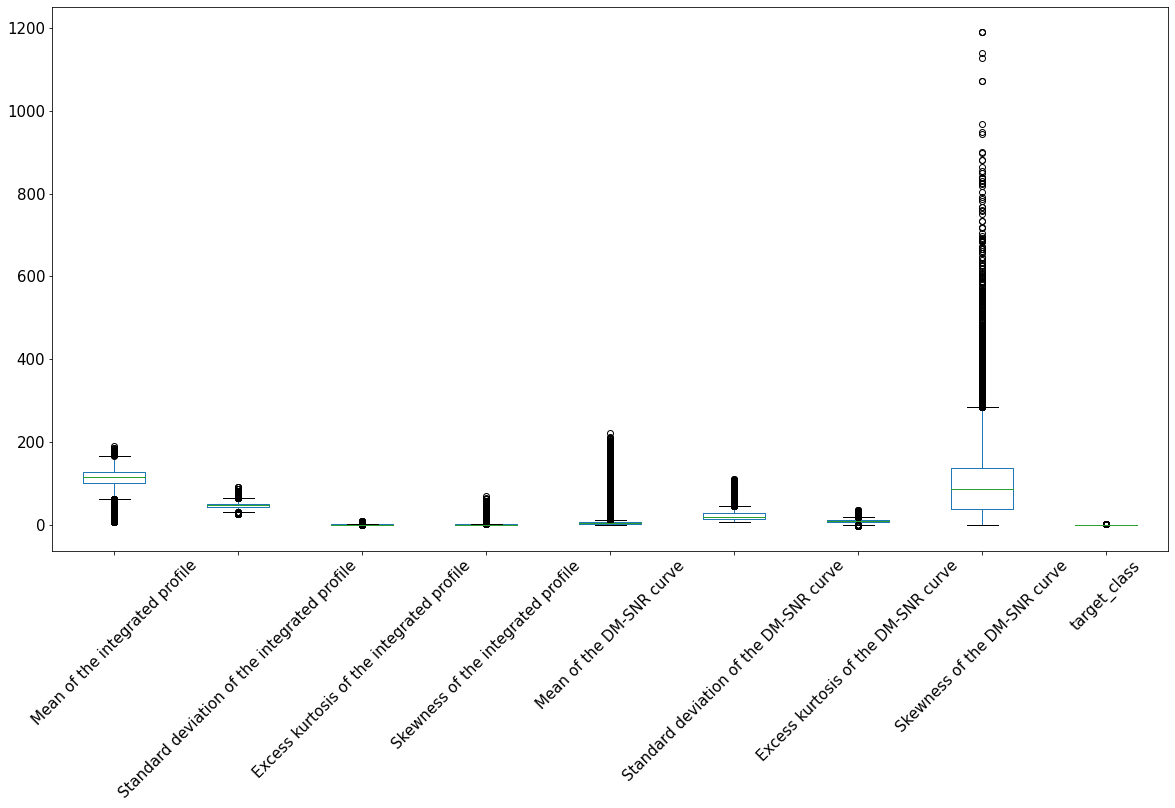

In [102]:
df.boxplot(grid=False,figsize=(20,10),rot=45,fontsize=15)

<Figure size 1080x1080 with 0 Axes>

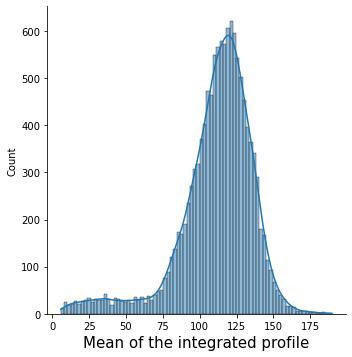

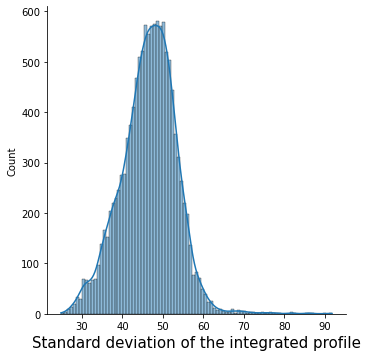

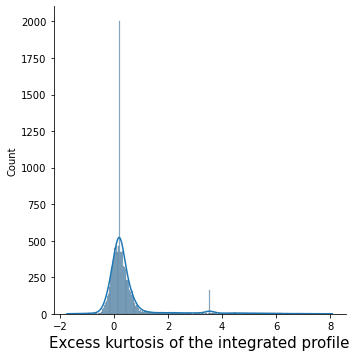

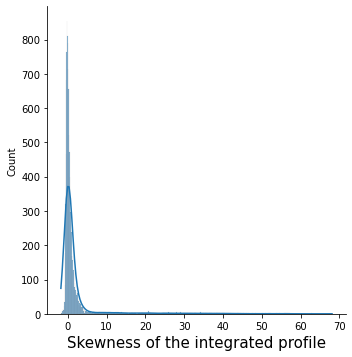

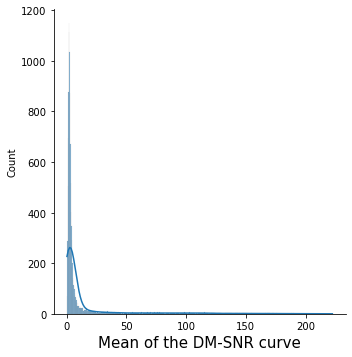

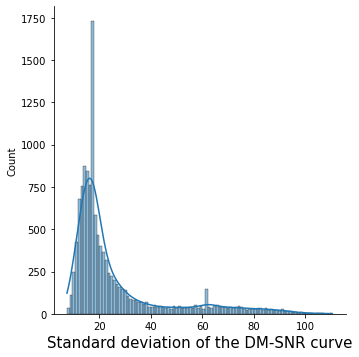

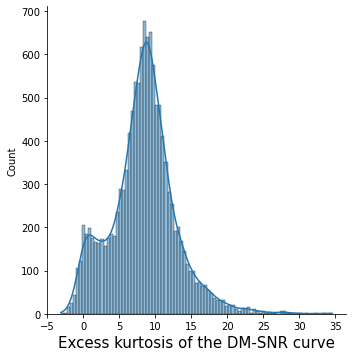

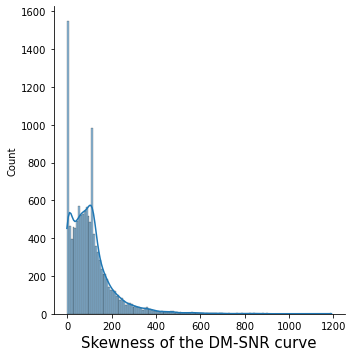

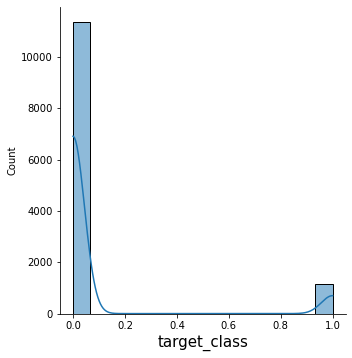

In [103]:
plt.figure(figsize=(15,15))
plot_ = 1
for column in df.columns:
    if plot_ <= 9:
        #ax = plt.subplot(3,3, plot_)
        sns.displot(df[column], kde=True)
        plt.xlabel(column, fontsize=15)
    plot_+=1
plt.show()

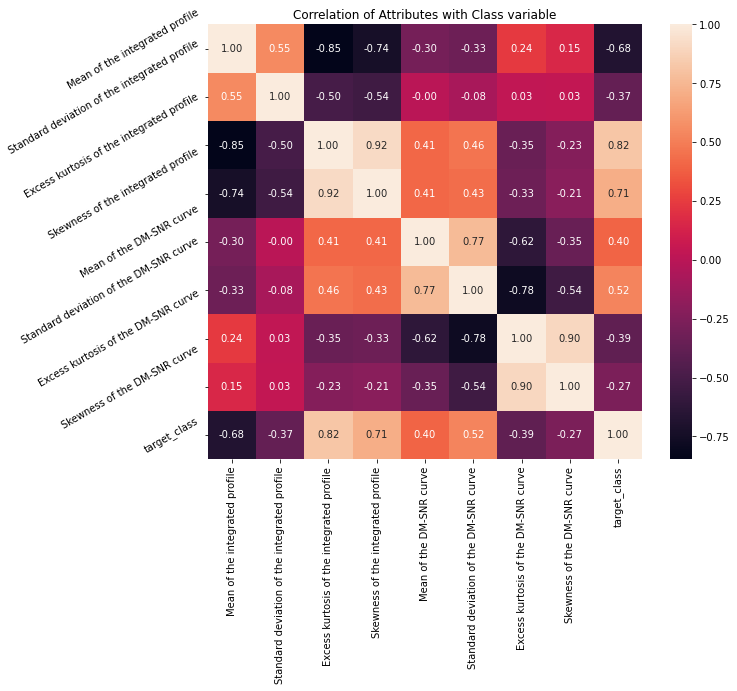

In [104]:
plt.figure(figsize=(10,8))
plt.title('Correlation of Attributes with Class variable')
a = sns.heatmap(df.corr(), square=True, annot=True, fmt='.2f', linecolor='white')
a.set_xticklabels(a.get_xticklabels(), rotation=90)
a.set_yticklabels(a.get_yticklabels(), rotation=30)           
plt.show()

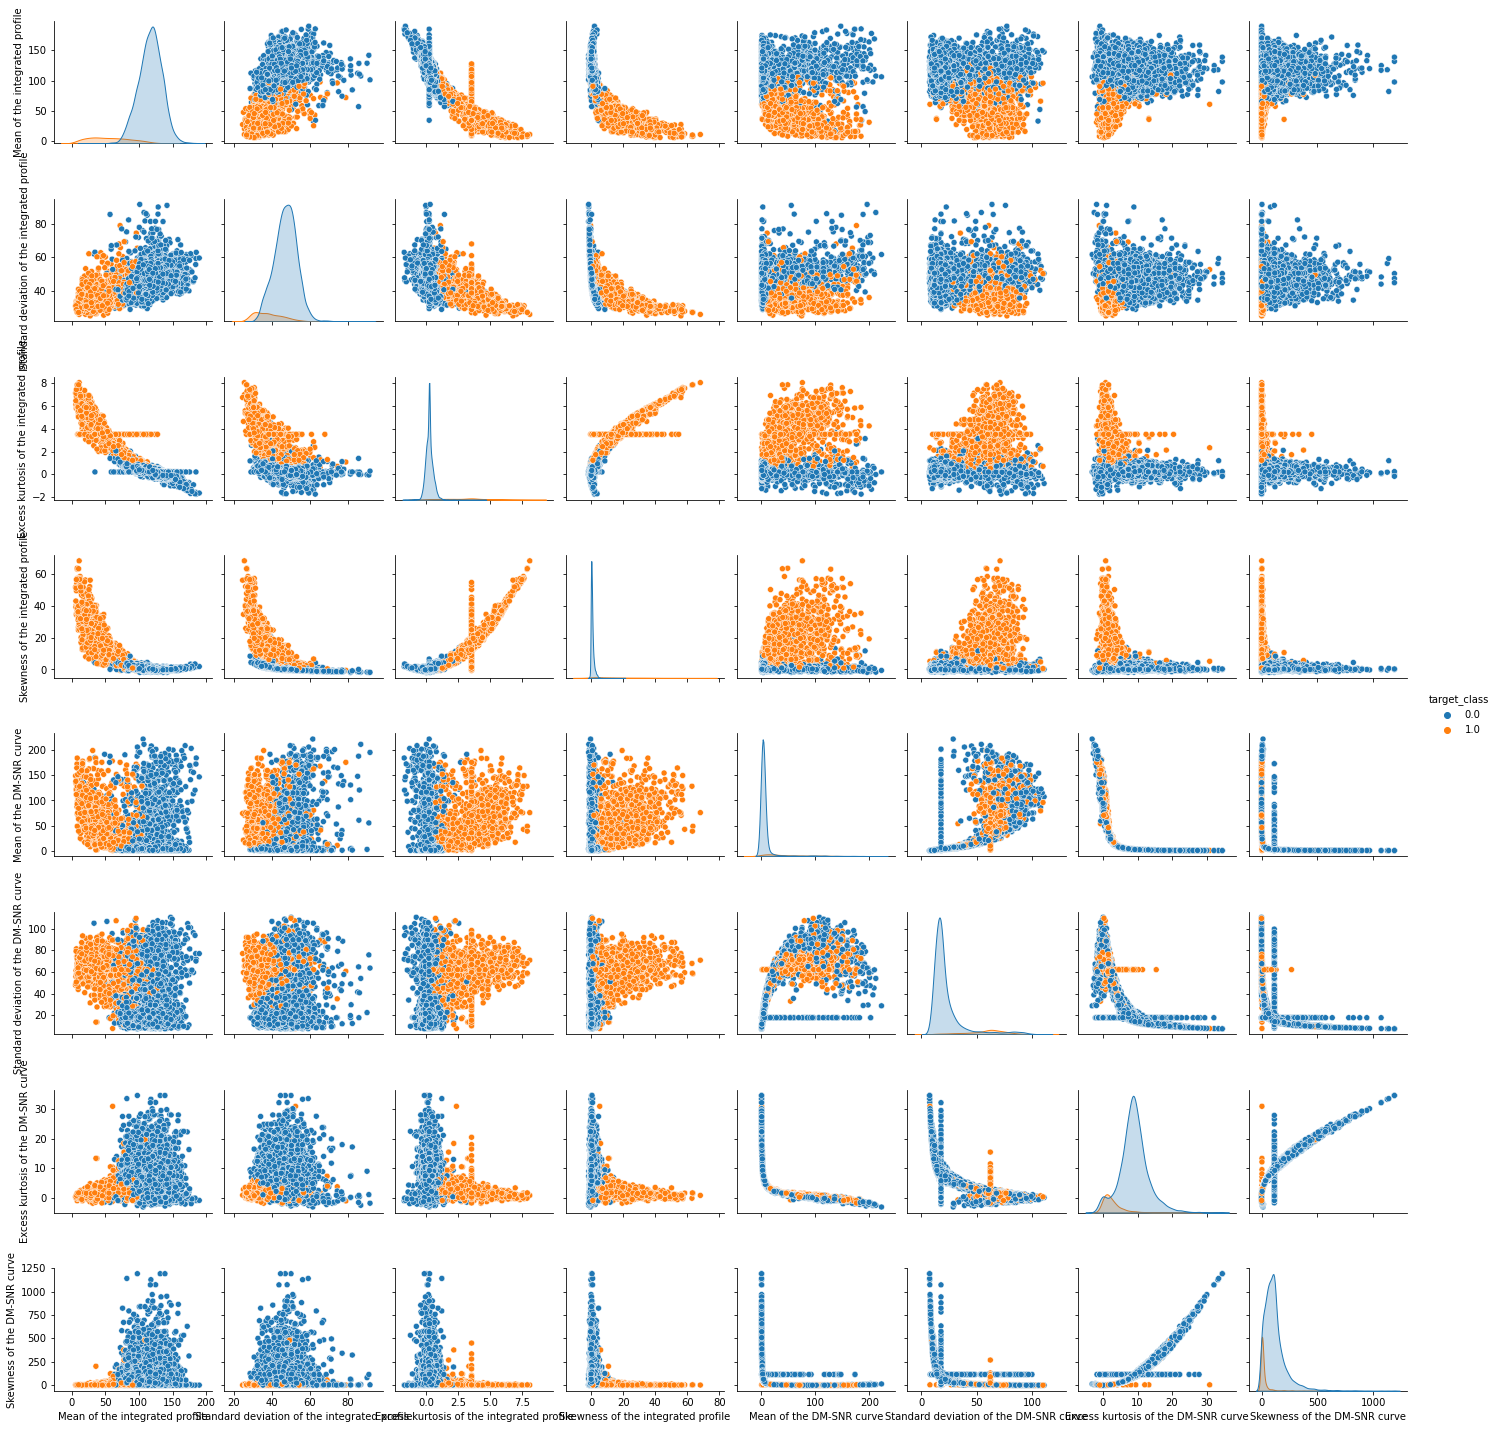

In [105]:
sns.pairplot(df, hue='target_class')

**2. Определите матрицу признаков и переменную таргета. Разделите трейновый набор трейн и тест с помощью train_test_split. Зафиксируйте размер тестовой выборки 0.2, а рэндом стэйт равный 0.** 

In [106]:
#TODO
X = df.drop('target_class', axis=1)
y = df['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**3. Используя StandartScaler отмасштабируйте матрицу признаков трейн и тест.**

In [107]:
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)

X_test_s = scaler.transform(X_test)
#TODO

**4. Обучите SVM Classifier на данных используя GridSearchCV: Попробуйте разные значения С, типа ядер, а так же значение гамма для rbf ядра. Подберите правильную метрику для оценки качества алгоритма. Убедитесь, что значения на тестровой и трейновой выборке сопоставимы и модель не переобучилась.**

In [108]:
# ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
svm = SVC()
param_grid = {'C':[0.01,0.1,1,1,5,10,15,20,25,45,50,75],
              'kernel':['linear','poly','rbf','sigmoid']}
grid = GridSearchCV(svm,param_grid)

%time grid.fit(X_train_s, y_train)
#TODO

CPU times: total: 2min 34s
Wall time: 2min 34s


GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 1, 5, 10, 15, 20, 25, 45, 50, 75],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']})

In [109]:
print(grid.best_params_)

{'C': 25, 'kernel': 'rbf'}


In [110]:
model = grid.best_estimator_
y_fit = model.predict(X_test_s)

**5. Постройте confusion_matrix и classification report.**

In [111]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_fit,
                            target_names=target_names))
#TODO

              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      2310
     class 1       0.92      0.86      0.89       195

    accuracy                           0.98      2505
   macro avg       0.96      0.93      0.94      2505
weighted avg       0.98      0.98      0.98      2505



In [112]:
df['target_class'].value_counts()[1]/len(df)

0.09191088397348877

<AxesSubplot:>

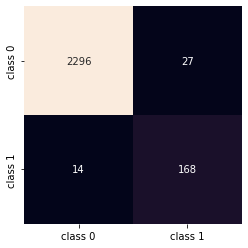

In [113]:
mat = confusion_matrix(y_test, y_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)

**6. Обучите Decision tree classifier на тех же данных, используя GridSearchCV подберите гиперпараметры для модели. Используйте ту же метрику, что и в задаче с SVM. Убедитесь, что алгоритм не переобучился**

In [114]:
dtc = DecisionTreeClassifier(random_state=0)

param_grid = {'max_depth':[2,3,4,5,6,10,15],
              'criterion':['gini', 'entropy', 'log_loss']}
grid = GridSearchCV(dtc,param_grid)

%time grid.fit(X_train_s, y_train)
#TODO

CPU times: total: 3.31 s
Wall time: 3.32 s


C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 105.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_messa

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 3, 4, 5, 6, 10, 15]})

In [115]:
print(grid.best_params_)

{'criterion': 'gini', 'max_depth': 4}


In [116]:
model = grid.best_estimator_
y_fit = model.predict(X_test_s)

**7. Постройте confusion_matrix и classification report.**

In [117]:
target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_fit,
                            target_names=target_names))
#TODO

              precision    recall  f1-score   support

     class 0       0.99      0.99      0.99      2310
     class 1       0.92      0.86      0.89       195

    accuracy                           0.98      2505
   macro avg       0.96      0.93      0.94      2505
weighted avg       0.98      0.98      0.98      2505



In [118]:
df['target_class'].value_counts()[1]/len(df)

0.09191088397348877

<AxesSubplot:>

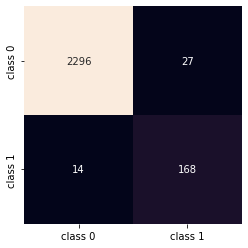

In [119]:
mat = confusion_matrix(y_test, y_fit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names,
            yticklabels=target_names)

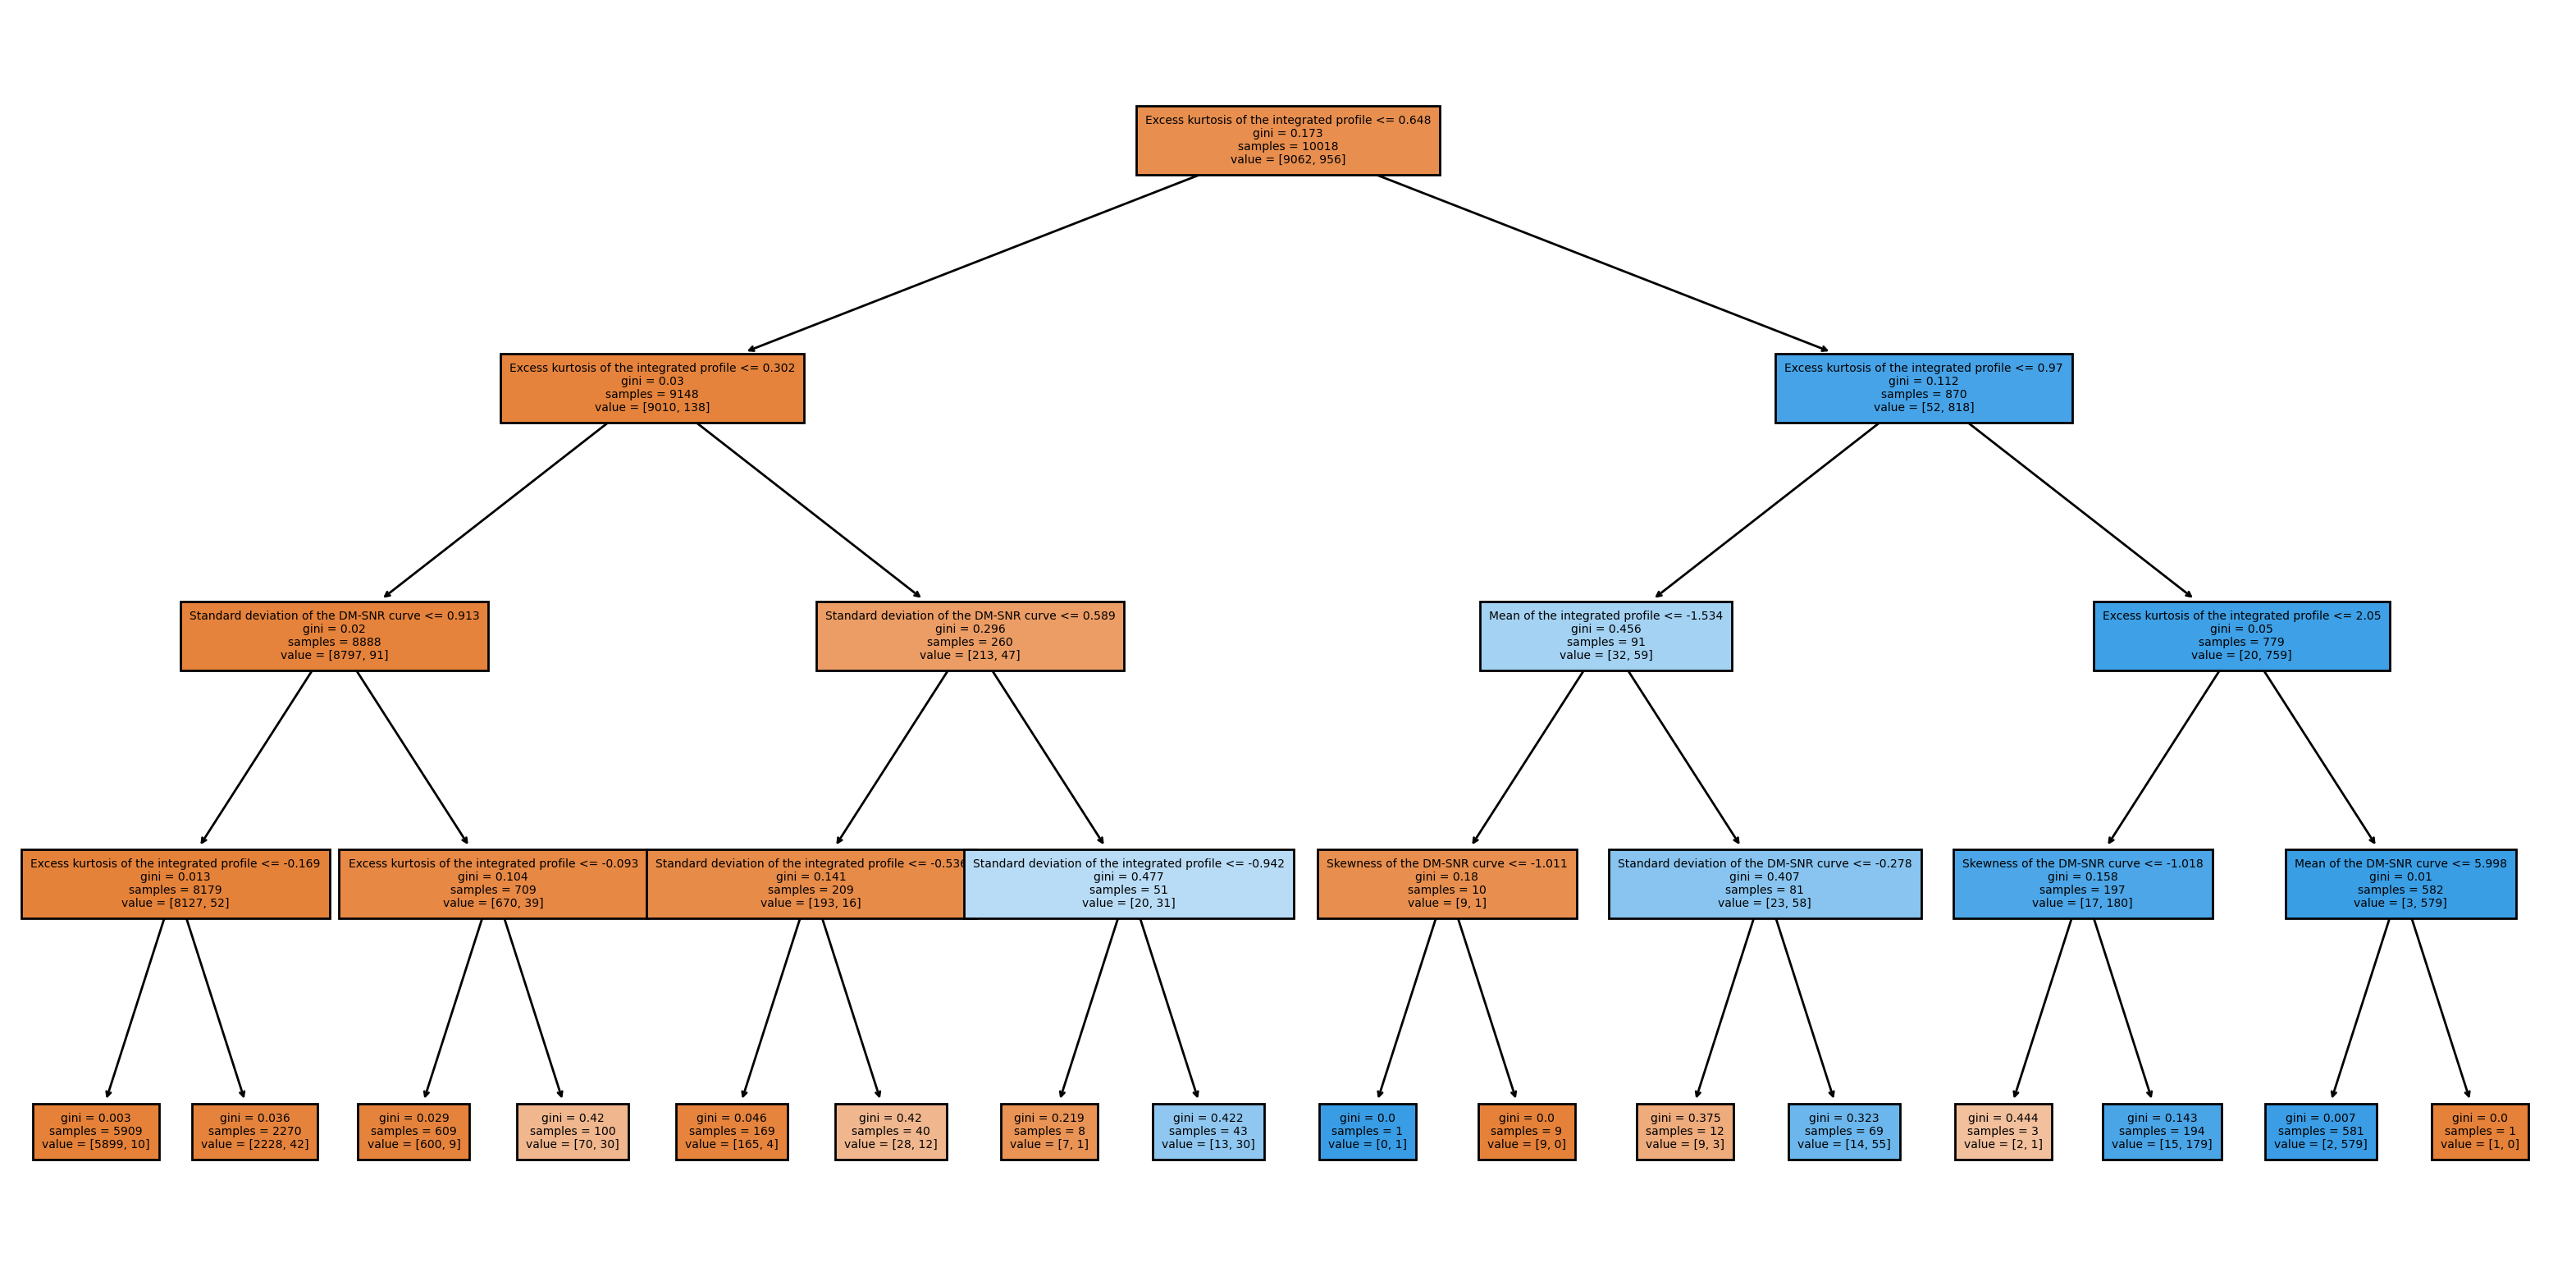

In [120]:
plt.figure(figsize=(20,10), dpi=200)
plot_tree(model,feature_names=X.columns,filled=True,fontsize=5);

**8. Напишите выводы по качеству моделей.**

Обе модели работаю хорошо, но DecisionTreeClassifier обучается гараздо быстрее. С другой стороны ML обученная по DecisionTreeClassifier будет долше отвекчать та как здесь присутствует ветвление 4-го уровня. Когда рекомендовваное 3 уровня. Обе модели ML переобучены их резултат равен 0.99, а на новых значениях 0.89.
Мне кажется модель не очень хорошо обучена, при нахождении пульсаров модель ошибавется в 25% случаев не называет пульсарами те звезды которыи ими являются.